In [1]:
n_samples_to_consider = 142246
n_labels_to_consider = 10000  # Up to 31466 but more than 10000 may OUT OF MEMORY
n_folds_to_process = 20

# Set the models, their params, etc
list_main_config_model_feature_etc = []
cfg2 = {
    'model': {
        'id': 'pMLP',
        'n_selfblend': 20,
        'epochs': 100,
        'custom_model_fit_function_name': 'model_fit_pytorch_Sophia'
    }
}
list_main_config_model_feature_etc.append(cfg2)

# Feature sets
list_features_id = ['t5', 'esm2S1280']

# Compute/not/when the scores
flag_compute_oof_predictions = True
flag_compute_stat_for_each_model = False
flag_compute_cafa_f1_for_each_model = flag_compute_stat_for_each_model and flag_compute_oof_predictions
flag_compute_each_blend_stat = False
flag_compute_cafa_f1_for_each_blend = flag_compute_each_blend_stat and flag_compute_oof_predictions
flag_compute_final_model_stat = True and flag_compute_oof_predictions

# Further params
cutoff_threshold_low = 0.1  # prediction < cutoff_threshold_low will be set to zero 
mode_submit = True  # Compute prediction for submission part and prepare submission file in required CAFA5 format.

# Save/not/what predictions
flag_save_final_submit_file = mode_submit  
flag_save_numpy_Y_pred_oof_blend = flag_compute_oof_predictions  
flag_save_numpy_Y_submit = mode_submit 

mode_downsample_train_default = '43k'
RANDOM_SEED = None
logs_file_path = 'logs.txt'

# Preparations 

In [2]:
%%capture 
%%time

# !pip install pandas
# !pip install seaborn
# !pip install scikit-learn
import time
t0start = time.time()
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import psutil
import datetime

def get_available_ram():
    virtual_memory = psutil.virtual_memory()
    available_ram = virtual_memory.available
    return available_ram


def log_available_ram( str_for_logging_optional = None):
    try:
        virtual_memory = psutil.virtual_memory()
        available_ram_bytes = virtual_memory.available
        available_ram_megabytes = available_ram_bytes / (1024 ** 2)
        available_ram_gigabytes = available_ram_bytes / (1024 ** 3)

        if str_for_logging_optional is not None:
            print(str_for_logging_optional)
        current_datetime = datetime.datetime.now()
        str1 = f"Available RAM: {available_ram_gigabytes:.2f} G  Current datetime: {current_datetime}"
        print( str1 ) 
        
        with open(logs_file_path, 'a') as file:
            if str_for_logging_optional is not None:
                file.write(str_for_logging_optional + '\n')
            file.write(str1 + '\n')
    except Exception as e:
        print(f"Error while appending data: {e}")        

        
log_available_ram('On start')


# !pip install torchmetrics
from torchmetrics import AUROC as torch_AUCROC
from torchmetrics import F1Score as torch_F1Score

# !pip install torchsummary
from torchsummary import summary as torchsummary
import os
import gc
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
import torch
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset , DataLoader


import random 
def seed_all(RANDOM_SEED):
    if RANDOM_SEED is not None: 
        try:
            SEED = RANDOM_SEED
            random.seed(SEED)
            np.random.seed(SEED)
            torch.manual_seed(SEED)
            torch.cuda.manual_seed_all(SEED)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        except Exception as e:
            print(f"Exception: {e}")
            
seed_all(RANDOM_SEED)      


# Optimizer "Sophia" sometimes better than Adam
!git clone https://github.com/kyegomez/Sophia.git
! python Sophia/setup.py install
!rm Sophia/Sophia/__init__.py
from Sophia.Sophia.Sophia import SophiaG

# Choose device - GPU or CPU and assign model to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps') 

# Load data


!!! Pay attention proteins ids should be the same as in all the files !!!!!!!!!!!!!!!!!! 

['t5', 'esm2S1280']
../input/cafa5-features-etc/T5_train_embeds_float32.npy
(142246, 1024)
[[ 0.04948843 -0.03293516  0.03247323]
 [-0.04461636  0.06492499 -0.08026284]]
protein_ids.shape: (142246,)
protein_ids[:15]: ['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366' 'P33681' 'P77596'
 'Q16787' 'Q59VP0' 'P13508' 'Q96S79' 'Q9VSA3' 'O94652' 'P35669' 'Q5MNZ6']
../input/cafa5-features-etc/T5_test_embeds_float32.npy
(141865, 1024)
[[ 0.05470492  0.06342026 -0.01531996]
 [ 0.09037268  0.08984205 -0.02388695]]
(141865,) ['Q9CQV8' 'P62259' 'P68510' 'P61982' 'O70456' 'P68254' 'P63101' 'A2AIG8'
 'Q3UX83' 'Q6PD03']
../input/23468234/train_embeds_esm2_t33_650M_UR50D.npy
(142246, 2304)
[[ 0.04948843 -0.03293516  0.03247323]
 [-0.04461636  0.06492499 -0.08026284]]
protein_ids.shape: (142246,)
protein_ids[:15]: ['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366' 'P33681' 'P77596'
 'Q16787' 'Q59VP0' 'P13508' 'Q96S

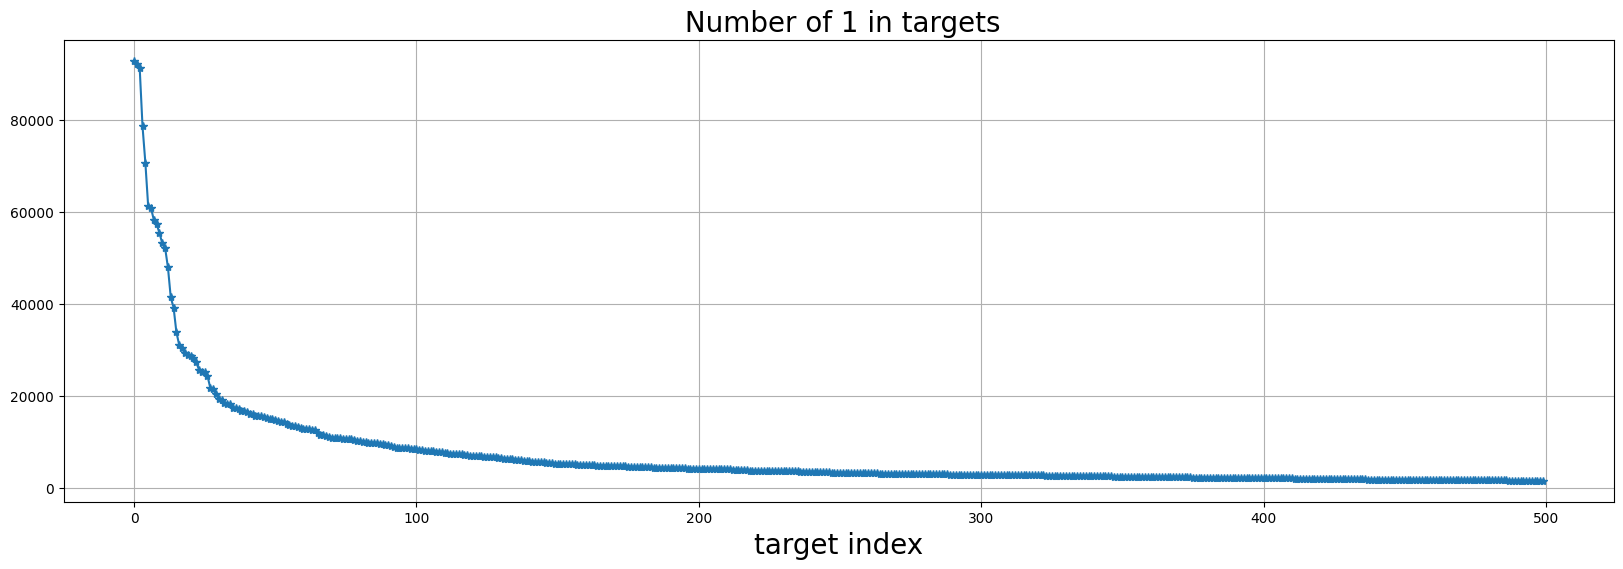

X mbytes: 1250.208984375
Y mbytes: 5426.2542724609375
X_submit mbytes: 1246.8603515625
After data load
Available RAM: 723.27 G  Current datetime: 2024-05-30 12:01:38.882467
(43189,) ['O73864' 'O95231' 'A0A0B4J1F4' 'P33681' 'P13508' 'P35669' 'Q5MNZ6'
 'P04632' 'P04021' 'O75908']
43189 [1, 2, 3, 5, 131079, 131080, 9, 131081, 13, 14]
(142246,) 5
0 28442
1 28449
2 28458
3 28467
4 28430
CPU times: user 39.4 s, sys: 7.6 s, total: 47 s
Wall time: 45.3 s


array([0, 1, 4, ..., 1, 3, 0], dtype=int32)

In [3]:
%%time 
print(device)
# 根据特征ID获取特征路径的函数
def get_paths_to_features(features_id):
    # 基础目录映射
    base_dir_map = {
        'esm2S2560': '../input/4637427/',
        't5': '../input/cafa5-features-etc/',
        'protbert': '../input/protbert-embeddings-for-cafa5/',
        'esm2S1280': '../input/23468234/',
        'esm2S320': '../input/315701375/',
        'esm2S640': '../input/8947923/',
        'esm2S480': '../input/3023750/'
    }

    # 文件名映射
    file_name_map = {
        'esm2S2560': ('train_embeds_esm2_t36_3B_UR50D.npy', 'train_ids_esm2_t36_3B_UR50D.npy', 'test_embeds_esm2_t36_3B_UR50D.npy', 'test_ids_esm2_t36_3B_UR50D.npy'),
        't5': ('T5_train_embeds_float32.npy', 'train_ids.npy', 'T5_test_embeds_float32.npy', 'test_ids.npy'),
        'protbert': ('train_embeddings.npy', 'train_ids.npy', 'test_embeddings.npy', 'test_ids.npy'),
        'esm2S1280': ('train_embeds_esm2_t33_650M_UR50D.npy', 'train_ids_esm2_t33_650M_UR50D.npy', 'test_embeds_esm2_t33_650M_UR50D.npy', 'test_ids_esm2_t33_650M_UR50D.npy'),
        'esm2S320': ('train_embeds_esm2_t6_8M_UR50D.npy', 'train_ids_esm2_t6_8M_UR50D.npy', 'test_embeds_esm2_t6_8M_UR50D.npy', 'test_ids_esm2_t6_8M_UR50D.npy'),
        'esm2S640': ('train_embeds_esm2_t30_150M_UR50D.npy', 'train_ids_esm2_t30_150M_UR50D.npy', 'test_embeds_esm2_t30_150M_UR50D.npy', 'test_ids_esm2_t30_150M_UR50D.npy'),
        'esm2S480': ('train_embeds_esm2_t12_35M_UR50D.npy', 'train_ids_esm2_t12_35M_UR50D.npy', 'test_embeds_esm2_t12_35M_UR50D.npy', 'test_ids_esm2_t12_35M_UR50D.npy')
    }

    dn = base_dir_map.get(features_id)
    fn_X, fn_protein_ids, fn_X_submit, fn_submit_protein_ids = file_name_map.get(features_id)
    
    return os.path.join(dn, fn_X), os.path.join(dn, fn_protein_ids), os.path.join(dn, fn_X_submit), os.path.join(dn, fn_submit_protein_ids)

################ load  features #########################

print(); print('!!! Pay attention proteins ids should be the same as in all the files !!!!!!!!!!!!!!!!!! '); print();

def get_features(list_features_id, verbose = 0):
    
    if verbose >= 100: print(list_features_id ); 
        
    X_submit,  submit_protein_ids = None, None
    for i0,features_id in enumerate(list_features_id):
        fn_X, fn_protein_ids, fn_X_submit, fn_submit_protein_ids  = get_paths_to_features(features_id)
        fn = fn_X 
        if verbose >= 100:  print(fn)
        if i0 == 0:
            X = np.load(fn).astype(np.float32)[:n_samples_to_consider, :]
        else:
            X = np.concatenate( [X, np.load(fn).astype(np.float32)[:n_samples_to_consider, :] ] , axis = 1 )
        if verbose >= 100: print(X.shape)
        if verbose >= 100: print(X[:2,:3])
        protein_ids  = np.load(fn_protein_ids)[:n_samples_to_consider ]
        vec_train_protein_ids = protein_ids
        if verbose >= 100: print('protein_ids.shape:', protein_ids.shape)
        if verbose >= 100: print('protein_ids[:15]:', protein_ids[:15])

            
        ################ load  features for submit #########################
        if mode_submit:

            fn = fn_X_submit
            if verbose >= 100: print(fn)
            if i0 == 0:
                X_submit = np.load(fn).astype(np.float32)
            else:
                X_submit = np.concatenate( [X_submit, np.load(fn).astype(np.float32) ] , axis = 1 )
            if verbose >= 100: print(X_submit.shape)
            if verbose >= 100: print(X_submit[:2,:3])

            fn = fn_submit_protein_ids
            submit_protein_ids = np.load(fn)
            if verbose >= 100: print(submit_protein_ids.shape, submit_protein_ids[:10])
    return X,vec_train_protein_ids,X_submit,  submit_protein_ids 

X,vec_train_protein_ids,X_submit,  submit_protein_ids = get_features(list_features_id, verbose = 100)
print('X_submit ==== ',X_submit)

############################ load targets and their ids  ######################################

# Load targets Y
from scipy import sparse
fn = '../input/cafa5-features-etc/Y_31466_sparse_float32.npz'
Y = sparse.load_npz(fn )
print('Y', Y.shape, 'loaded')
Y = Y[:n_samples_to_consider,:n_labels_to_consider].toarray()
print('Y', Y.shape, 'truncated')
n_labels_to_consider = Y.shape[1] # in case n_labels_to_consider is greater that Y.shape we decrease it

fn = '../input/cafa5-features-etc/Y_31466_labels.npy'
Y_labels = np.load(fn, allow_pickle=True )[:n_labels_to_consider]
labels_to_consider = Y_labels
print(Y_labels.shape)
print(Y_labels[:20])

# %%time
if 1:
    v = Y.sum(axis = 0)
    plt.figure(figsize = (20,6))
    plt.plot(v[:500], '*-')
    plt.grid()
    plt.title(' Number of 1 in targets',fontsize = 20 )
    plt.xlabel('target index', fontsize = 20 )
    plt.show()


import gc
gc.collect()

print('X mbytes:', X.nbytes/1024/1024)
print('Y mbytes:', Y.nbytes/1024/1024)
try :
    print('X_submit mbytes:', X_submit.nbytes/1024/1024)
except:
    pass
log_available_ram('After data load')

## Prepare possible downsampling of the train 
dict_set_allowed_train_indexes = {}

fn = '../input/cafa5-features-etc/train_ids_cut43k.npy'
allowed_train_ids = np.load(fn)
print(allowed_train_ids.shape, allowed_train_ids[:10])
vec_allowed_train_indexes_43k =  [ ix for ix in range(len(vec_train_protein_ids)) if  vec_train_protein_ids[ix] in ( allowed_train_ids ) ] 
set_allowed_train_indexes_43k = set( vec_allowed_train_indexes_43k  )
dict_set_allowed_train_indexes['43k'] = set_allowed_train_indexes_43k
print(len(dict_set_allowed_train_indexes['43k']), list(dict_set_allowed_train_indexes['43k'])[:10] )

def get_downsampled_IX_train(IX_train, mode_downsample_train ):
    if mode_downsample_train in dict_set_allowed_train_indexes.keys():
        set_allowed_train_indexes = dict_set_allowed_train_indexes[ mode_downsample_train ]
        IX_train = [t for t in IX_train if t in set_allowed_train_indexes ]
    elif 'random_subsample_percent' in str(mode_downsample_train):
        random_subsample_percent = float( str(mode_downsample_train).split('_')[-1] ) # 'random_subsample_percent_90'
        IX_train = np.random.permutation(IX_train)[ :int(len(IX_train)*random_subsample_percent / 100  )]
    
    return IX_train

# Load partition to folds for cross-validation
fn = '../input/cafa5-features-etc/random_folds/folds_gkf.npy'
folds = np.load(fn)[:n_samples_to_consider]
print(folds.shape, len(set(folds)))
for k in set(folds):
    m = folds == k
    print(k, m.sum() )
folds

# Define neural networks

In [4]:
class Model5(nn.Module):
    def __init__(self,input_features,output_features):
        super().__init__()
        
        self.activation = nn.PReLU()
        
        self.bn1 = nn.BatchNorm1d(input_features)
        self.fc1 = nn.Linear(input_features, 800)
        self.ln1 = nn.LayerNorm(800, elementwise_affine=True)
        
        self.bn2 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800, 600)
        self.ln2 = nn.LayerNorm(600, elementwise_affine=True)
        
        self.bn3 = nn.BatchNorm1d(600)
        self.fc3 = nn.Linear(600, 400)
        self.ln3 = nn.LayerNorm(400, elementwise_affine=True)
        
        self.bn4 = nn.BatchNorm1d(1200)
        self.fc4 = nn.Linear(1200, output_features)
        self.ln4 = nn.LayerNorm(output_features, elementwise_affine=True)
        
        self.sigm = nn.Sigmoid()
    def forward(self,inputs):

        fc1_out = self.bn1(inputs)
        fc1_out = self.ln1(self.fc1(inputs))
        fc1_out = self.activation(fc1_out)
        
        x = self.bn2(fc1_out)
        
        x = self.ln2(self.fc2(x))
        x = self.activation(x)
        
        x = self.bn3(x)
        
        x = self.ln3(self.fc3(x))
        x = self.activation(x)
        
        x = torch.cat([x, fc1_out], axis = -1)
        
        x = self.bn4(x)
        
        x = self.ln4(self.fc4(x))
        out = self.sigm(x)
        return out


In [5]:
%%time
# !pip install keras
# !pip install tensorflow
import gc
import time 
import numpy as np
try: 
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import f1_score
    from sklearn.linear_model import Ridge
    from sklearn.neural_network import MLPRegressor
    import lightgbm as lgbm
    from sklearn.multioutput import MultiOutputRegressor
    from sklearn.multioutput import MultiOutputClassifier  
    
    from catboost import CatBoostRegressor
    from catboost import CatBoostClassifier    
except Exception as e:
    print(f'Exception importing models {e} ')
    pass


import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input,  Concatenate, Dropout, BatchNormalization, Activation
from keras.layers import LayerNormalization

Exception importing models No module named 'lightgbm' 


2024-05-30 12:02:16.154510: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 12:02:16.200873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 12:02:17.047732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


CPU times: user 1.57 s, sys: 147 ms, total: 1.72 s
Wall time: 1.71 s


# Get model

In [6]:
def get_model(model_config):
    
    str_model_id = str(model_config['id'])
    if model_config['id'] == 'pMLP':
        model = Model5(X.shape[1],Y.shape[1])
        model.to(device)
    elif model_config['id'] == 'Ridge':
        print('get_model Ridge')
        alpha = model_config.get('alpha',10)
        str_model_id = 'Ridge'+str(alpha)
        model = Ridge(alpha=alpha)
        
    elif model_config['id'] == 'skMLP':
        print('get_model skMLP')
        str_model_id = 'skMLP'
        max_iter = model_config.get('max_iter',500); str_model_id += '_MI'+str(max_iter) 
        random_state = model_config.get('random_state',np.random.randint(0,100)); str_model_id += '_RS'+str(random_state)
        hidden_layer_sizes = model_config.get('Layers', (100,) ); str_model_id += '_HL'+str(hidden_layer_sizes)
        alpha = model_config.get('alpha', 1e-4 ); str_model_id += '_alpha'+str(alpha)
        learning_rate_init = model_config.get('LR', 0.001 ); str_model_id += '_LR'+str(learning_rate_init)
        model = MLPRegressor( max_iter=max_iter , random_state=random_state, hidden_layer_sizes = hidden_layer_sizes, alpha= alpha, learning_rate_init = learning_rate_init  )
        
    elif model_config['id'] == 'KMLP_simple':
        print('get_model KMLP_simple')
        model = Sequential(); str_model_id = 'KMLP_simple'
        
        nfeats = X.shape[1]#  model_config['input_dim']
        nlabels = Y.shape[1]#  model_config['output_dim']
        
        layer_dim = 500
        model.add(Dense(layer_dim, activation='relu', input_dim=nfeats   ) )  ; str_model_id += '_L1_'+str(layer_dim) 
        model.add(BatchNormalization()) ; str_model_id += '_BN'
        droupout_rate = 0.1
        model.add(Dropout(droupout_rate)) ; str_model_id += '_DR'+str( np.round(droupout_rate ,2) ) 
        
        layer_dim = 800
        model.add(Dense(layer_dim, activation='relu'   ) )  ; str_model_id += '_L2_'+str(layer_dim) 
        model.add(BatchNormalization()) ; str_model_id += '_BN'
        droupout_rate = 0.1
        model.add(Dropout(droupout_rate)) ; str_model_id += '_DR'+str( np.round(droupout_rate ,2) ) 
        
        ######### Last layer ########################################################################################
        model.add(Dense(nlabels, activation='sigmoid'   ))
        
        model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[keras.metrics.AUC()] )
        
        
    elif model_config['id'] == 'KMLP':   
        print('get_model KMLP')
        model = Sequential(); str_model_id = 'KMLP'
        
        layers_sizes = model_config['Layers']
        list_droupouts = model_config.get('Dropouts' ,  []  )
        list_batchnormalization = model_config.get( 'BatchNormalizations', [] )
        
        nfeats = X.shape[1]#  model_config['input_dim']
        nlabels = Y.shape[1]#  model_config['output_dim']
        
        ######### First Layer #################################################################################
        i_layer = 0 
        layer_dim = layers_sizes[i_layer]
        model.add(Dense(layer_dim, activation='relu', input_dim=nfeats   ) )  ; str_model_id += '_L1_'+str(layer_dim) 
        if len( list_batchnormalization ) > i_layer:
            if list_batchnormalization[i_layer]:
                model.add(BatchNormalization())
                str_model_id += '_BN'
        if (len( list_droupouts ) > i_layer) and ( list_droupouts[i_layer] is not None ):
            droupout_rate  = list_droupouts[i_layer]
            model.add(Dropout(droupout_rate))
            str_model_id += '_DR'+str( np.round(droupout_rate ,2) ) 
            
        ######### Middle layers ##########################################################################################
        for i_layer in range(1, len( layers_sizes ) ) : 
            layer_dim = layers_sizes[i_layer]
            if layer_dim is None: break  
            model.add(Dense(layer_dim, activation='relu' ));
            str_model_id += '_L'+str(i_layer+1)+'_'+str(layer_dim)    
            if len( list_batchnormalization ) > i_layer:
                if list_batchnormalization[i_layer]:
                    model.add(BatchNormalization())
                    str_model_id += '_BN'
            if (len( list_droupouts ) > i_layer) and ( list_droupouts[i_layer] is not None ):
                droupout_rate  = list_droupouts[i_layer]
                model.add(Dropout(droupout_rate))
                str_model_id += '_DR'+str( np.round(droupout_rate ,2) )         
        
        ######### Last layer ########################################################################################
        model.add(Dense(nlabels, activation='sigmoid'   ))
        model.compile(loss='binary_crossentropy',
                        optimizer='adam',
                        metrics=[keras.metrics.AUC()])           
        
    elif model_config['id'] == 'gpuLogReg':
        print('get_model gpuLogReg')
        import torch
        if torch.cuda.is_available():
            from cuml.linear_model import LogisticRegression as CULogisticRegression        
            model = MultiOutputClassifier(estimator= CULogisticRegression( ) )# **params ) )
            str_model_id = 'gpuLogReg'
            
    elif model_config['id'] == 'gpuCatBClasdefault':
        print('get_model gpuCatBClasdefault')
        model = MultiOutputClassifier(estimator= CatBoostClassifier(task_type = 'GPU', verbose = 0 ))# **params ) )
        str_model_id = model_cfg[0] 

    elif model_config['id'] == 'gpuCatBdefault': 
        print('get_model gpuCatBdefault')
        model = MultiOutputRegressor(estimator= CatBoostRegressor(task_type = 'GPU', verbose = 0 ))# **params ) )
        str_model_id = model_cfg[0] 

    elif model_config['id'] == 'CatBdefault': 
        print('get_model CatBdefault')
        model = MultiOutputRegressor(estimator= CatBoostRegressor(verbose = 0 ))# **params ) )
        str_model_id = model_cfg[0] 
    
    elif model_config['id'] == 'LGBdefault': 
        print('get_model LGBdefault')
        model = MultiOutputRegressor(estimator=lgbm.LGBMRegressor())# **params ) )
        str_model_id = 'LGBdefault'
            
    namepostfix = model_config.get('namepostfix',"")
    str_model_id += namepostfix
    
    return model, str_model_id

# Fit model function 

In [7]:
%%time
def model_fit(model , X_train, Y_train, model_config , str_model_id = '', verbose = 1000 ):
    print('model_fit')
    if verbose >= 100:
        print('model_fit', str_model_id,  model_config )

    if 'custom_model_fit_function_name' in model_config.keys():
        str_func_name = model_config['custom_model_fit_function_name']
        if verbose >= 1000: print('str_func_name', str_func_name)
        globals()[str_func_name](model , X_train, Y_train, model_config , str_model_id = '', verbose = 1000 ) # Call a function with name "str_func_name"

    elif  'pMLP' in str(model_config['id']):
        model_fit_pytorch( model , X_train, Y_train, model_config , str_model_id, verbose )
        
    else:
        
        dict_prm_for_fit = {t : model_config[t] for t in ['epochs' ,   'batch_size' , 'verbose']   if t in model_config.keys()  }
        if len( dict_prm_for_fit ) == 0:
            model.fit( X_train, Y_train  )
        else:
            model.fit( X_train, Y_train , **dict_prm_for_fit  )
            
def model_fit_pytorch( model , X_train, Y_train, model_config , str_model_id = '', verbose = 1000 ):
    print('model_fit_pytorch ======= ',model)
    criterion = model_config.get( 'criterion', nn.BCELoss() )
    max_epoch = model_config.get('epochs', 10 )
    BATCH_SIZE = model_config.get('batch_size',  128 )
    LEARNING_RATE = model_config.get( 'LR' , 0.001 )
    
    optimizer = model_config.get( 'optimizer' ,  torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  )
    lr_sched = model_config.get( 'lr_scheduler' , None ) 

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train, Y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

    if verbose >= 100:
        print(str_model_id, 'Start model training. X_train.shape, Y_train.shape', X_train.shape, Y_train.shape )
    log_available_ram(f'After X_train initialization. Right before model train {str_model_id}')        
    
    ##################### Model Training ###################################################
    for epoch in range(max_epoch):
        t0_epoch = time.time()
        model.train() 
        for i_batch, (x_batch, y_batch) in enumerate(train_dataloader): 
            optimizer.zero_grad() 
            preds = model(x_batch)
            loss = criterion(preds, y_batch) 
            loss.backward() 
            optimizer.step() 

        if lr_sched is not None:
            lr_sched.step() 

        if (verbose >= 10 ) and (i_batch % 100 == 0)  :
            print(str_model_id,  f'Epoch: {epoch}, batch: {i_batch},  train loss on batch: {loss.item():12.5f} , time: {time.time() - t0:.1f} ' )         
            
            
def model_fit_pytorch_Sophia(  model , X_train, Y_train, model_config , str_model_id = '', verbose = 1000 ):
    criterion = model_config.get( 'criterion', nn.BCELoss() )
    max_epoch = model_config.get('epochs', 50 ) 
    BATCH_SIZE = model_config.get('batch_size',  128 )
    LEARNING_RATE = model_config.get( 'LR' , 0.001 )
    criterion = model_config.get( 'criterion', nn.BCELoss() )

    lr = LEARNING_RATE 
    optimizer = SophiaG(model.parameters(),lr , betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

    
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train, Y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

    if verbose >= 100:
        print(str_model_id, 'Start model training. X_train.shape, Y_train.shape', X_train.shape, Y_train.shape )
    log_available_ram(f'After X_train initialization. Right before model train {str_model_id}')        
        
    ##################### Model Training ###################################################
    for epoch in range(max_epoch):
        print('epoch ======= ',epoch)
        t0_epoch = time.time()
        model.train() 
        for i_batch, (x_batch, y_batch) in enumerate(train_dataloader): 
            optimizer.zero_grad()   
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward() 
            optimizer.step() 


        if (verbose >= 10 ) and (i_batch % 100 == 0)  :
            print(str_model_id,  f'Epoch: {epoch}, batch: {i_batch},  train loss on batch: {loss.item():12.5f} , time: {time.time() - t0:.1f} ' )         

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs


# Models predict function

In [8]:
def model_predict(model , XX,  model_config , str_model_id = '', verbose = 1000 ):
    
    if verbose >= 100:
        print('model_predict',  str_model_id,  model_config )

    if  'pMLP' in str(model_config['id']):
        Y_pred = model_predict_pytorch( model ,XX,  model_config , str_model_id, verbose )
    else:
        Y_pred = model.predict( XX ) 
    
    return Y_pred


def model_predict_pytorch( model ,XX,  model_config , str_model_id = '', verbose = 1000 ):
    print('model_predict_pytorch model ====== ',model_predict_pytorch)
    print('model_predict_pytorch xx ====== ',XX)
    t0_submit = time.time()
    XX = torch.tensor(XX, dtype=torch.float32).to(device)
    
    model.eval()
    with torch.no_grad():
        Y_pred = model(XX).cpu().numpy()
        
    if verbose >= 100: print(str_model_id,  f'Y_pred.shape: {Y_pred.shape}, type(Y_pred): {type(Y_pred)}, predict on submit time: {time.time() - t0_submit :.1f} ' )  

    return Y_pred

# CAFA5 metric 

In [9]:
%%time

# Evaluation for CAFA 
# https://github.com/BioComputingUP/CAFA-evaluator
flag_correct_metric_computation_bug_found_by_Anton = True
# https://www.kaggle.com/competitions/cafa-5-protein-function-prediction/discussion/420241 - Anton Vakhrushev - correcting error in the initial code of the metric computation - please upvote 
import numpy as np
import pandas as pd
import multiprocessing as mp
import copy
import logging

class Graph:
    """
    Ontology class. One ontology == one namespace
    DAG is the adjacence matrix (sparse) which represent a Directed Acyclic Graph where
    DAG(i,j) == 1 means that the go term i is_a (or is part_of) j
    Parents that are in a different namespace are discarded
    """
    def __init__(self, namespace, terms_dict, ia_dict=None, orphans=False):
        """
        terms_dict = {term: {name: , namespace: , def: , alt_id: , rel:}}
        """
        self.namespace = namespace
        self.dag = []  # [[], ...] terms (rows, axis 0) x parents (columns, axis 1)
        self.terms_dict = {}  # {term: {index: , name: , namespace: , def: }  used to assign term indexes in the gt
        self.terms_list = []  # [{id: term, name:, namespace: , def:, adg: [], children: []}, ...]
        self.idxs = None  # Number of terms
        self.order = None
        self.toi = None
        self.ia = None

        rel_list = []
        for self.idxs, (term_id, term) in enumerate(terms_dict.items()):
            rel_list.extend([[term_id, rel, term['namespace']] for rel in term['rel']])
            self.terms_list.append({'id': term_id, 'name': term['name'], 'namespace': namespace, 'def': term['def'],
                                 'adj': [], 'children': []})
            self.terms_dict[term_id] = {'index': self.idxs, 'name': term['name'], 'namespace': namespace, 'def': term['def']}
            for a_id in term['alt_id']:
                self.terms_dict[a_id] = copy.copy(self.terms_dict[term_id])
        self.idxs += 1

        self.dag = np.zeros((self.idxs, self.idxs), dtype='bool')

        # id1 term (row, axis 0), id2 parent (column, axis 1)
        for id1, id2, ns in rel_list:
            if self.terms_dict.get(id2):
                i = self.terms_dict[id1]['index']
                j = self.terms_dict[id2]['index']
                self.dag[i, j] = 1
                self.terms_list[i]['adj'].append(j)
                self.terms_list[j]['children'].append(i)
                logging.debug("i,j {},{} {},{}".format(i, j, id1, id2))
            else:
                logging.debug('Skipping branch to external namespace: {}'.format(id2))
        logging.debug("dag {}".format(self.dag))
        # Topological sorting
        self.top_sort()
        logging.debug("order sorted {}".format(self.order))

        if orphans:
            self.toi = np.arange(self.dag.shape[0])  # All terms, also those without parents
        else:
            self.toi = np.nonzero(self.dag.sum(axis=1) > 0)[0]  # Only terms with parents
        logging.debug("toi {}".format(self.toi))

        if ia_dict is not None:
            self.set_ia(ia_dict)

        return

    def top_sort(self):
        """
        Takes a sparse matrix representing a DAG and returns an array with nodes indexes in topological order
        https://en.wikipedia.org/wiki/Topological_sorting
        """
        indexes = []
        visited = 0
        (rows, cols) = self.dag.shape

        # create a vector containing the in-degree of each node
        in_degree = self.dag.sum(axis=0)
        # logging.debug("degree {}".format(in_degree))

        # find the nodes with in-degree 0 (leaves) and add them to the queue
        queue = np.nonzero(in_degree == 0)[0].tolist()
        # logging.debug("queue {}".format(queue))

        # for each element of the queue increment visits, add them to the list of ordered nodes
        # and decrease the in-degree of the neighbor nodes
        # and add them to the queue if they reach in-degree == 0
        while queue:
            visited += 1
            idx = queue.pop(0)
            indexes.append(idx)
            in_degree[idx] -= 1
            l = self.terms_list[idx]['adj']
            if len(l) > 0:
                for j in l:
                    in_degree[j] -= 1
                    if in_degree[j] == 0:
                        queue.append(j)

        # if visited is equal to the number of nodes in the graph then the sorting is complete
        # otherwise the graph can't be sorted with topological order
        if visited == rows:
            self.order = indexes
        else:
            raise Exception("The sparse matrix doesn't represent an acyclic graph")

    def set_ia(self, ia_dict):
        self.ia = np.zeros(self.idxs, dtype='float')
        for term_id in self.terms_dict:
            if ia_dict.get(term_id):
                self.ia[self.terms_dict[term_id]['index']] = ia_dict.get(term_id)
            else:
                logging.debug('Missing IA for term: {}'.format(term_id))
        # Convert inf to zero
        np.nan_to_num(self.ia, copy=False, nan=0, posinf=0, neginf=0)
        self.toi = np.nonzero(self.ia > 0)[0]


class Prediction:
    """
    The score matrix contains the scores given by the predictor for every node of the ontology
    """
    def __init__(self, ids, matrix, idx, namespace=None):
        self.ids = ids
        self.matrix = matrix  # scores
        self.next_idx = idx
        # self.n_pred_seq = idx + 1
        self.namespace = namespace

    def __str__(self):
        return "\n".join(["{}\t{}\t{}".format(index, self.matrix[index], self.namespace) for index, _id in enumerate(self.ids)])


class GroundTruth:
    def __init__(self, ids, matrix, namespace=None):
        self.ids = ids
        self.matrix = matrix
        self.namespace = namespace


def propagate(matrix, ont, order, mode='max'):
    """
    Update inplace the score matrix (proteins x terms) up to the root taking the max between children and parents
    """
    if matrix.shape[0] == 0:
        raise Exception("Empty matrix")

    deepest = np.where(np.sum(matrix[:, order], axis=0) > 0)[0][0]
    if deepest.size == 0:
        raise Exception("The matrix is empty")

    # Remove leaves
    order_ = np.delete(order, [range(0, deepest)])

    for i in order_:
        # Get direct children
        children = np.where(ont.dag[:, i] != 0)[0]
        if children.size > 0:
            cols = np.concatenate((children, [i]))
            if mode == 'max':
                matrix[:, i] = matrix[:, cols].max(axis=1)
            elif mode == 'fill':
                rows = np.where(matrix[:, i] == 0)[0]
                if rows.size:
                    idx = np.ix_(rows, cols)
                    if flag_correct_metric_computation_bug_found_by_Anton:
                        matrix[rows, i] = matrix[idx].max(axis=1) #  matrix[idx].max(axis=1)[0] # Correction: https://www.kaggle.com/competitions/cafa-5-protein-function-prediction/discussion/420241
                    else:
                        # Old way - not corrected
                        matrix[rows, i] = matrix[idx].max(axis=1)[0] # Correction: https://www.kaggle.com/competitions/cafa-5-protein-function-prediction/discussion/420241
                        
    return


def obo_parser(obo_file, valid_rel=("is_a", "part_of")):
    """
    Parse a OBO file and returns a list of ontologies, one for each namespace.
    Obsolete terms are excluded as well as external namespaces.
    """
    term_dict = {}
    term_id = None
    namespace = None
    name = None
    term_def = None
    alt_id = []
    rel = []
    obsolete = True
    with open(obo_file) as f:
        for line in f:
            line = line.strip().split(": ")
            if line and len(line) > 1:
                k = line[0]
                v = ": ".join(line[1:])
                if k == "id":
                    # Populate the dictionary with the previous entry
                    if term_id is not None and obsolete is False and namespace is not None:
                        term_dict.setdefault(namespace, {})[term_id] = {'name': name,
                                                                       'namespace': namespace,
                                                                       'def': term_def,
                                                                       'alt_id': alt_id,
                                                                       'rel': rel}
                    # Assign current term ID
                    term_id = v

                    # Reset optional fields
                    alt_id = []
                    rel = []
                    obsolete = False
                    namespace = None

                elif k == "alt_id":
                    alt_id.append(v)
                elif k == "name":
                    name = v
                elif k == "namespace" and v != 'external':
                    namespace = v
                elif k == "def":
                    term_def = v
                elif k == 'is_obsolete':
                    obsolete = True
                elif k == "is_a" and k in valid_rel:
                    s = v.split('!')[0].strip()
                    rel.append(s)
                elif k == "relationship" and v.startswith("part_of") and "part_of" in valid_rel:
                    s = v.split()[1].strip()
                    rel.append(s)

        # Last record
        if obsolete is False and namespace is not None:
            term_dict.setdefault(namespace, {})[term_id] = {'name': name,
                                                          'namespace': namespace,
                                                          'def': term_def,
                                                          'alt_id': alt_id,
                                                          'rel': rel}
    return term_dict


def gt_parser(gt_file, ontologies):
    """
    Parse ground truth file. Discard terms not included in the ontology.
    """
    gt_dict = {}
    with open(gt_file) as f:
        for line in f:
            line = line.strip().split()
            if line:
                p_id, term_id = line[:2]
                for ont in ontologies:
                    if term_id in ont.terms_dict:
                        gt_dict.setdefault(ont.namespace, {}).setdefault(p_id, []).append(term_id)
                        break

    gts = {}
    for ont in ontologies:
        if gt_dict.get(ont.namespace):
            matrix = np.zeros((len(gt_dict[ont.namespace]), ont.idxs), dtype='bool')
            ids = {}
            for i, p_id in enumerate(gt_dict[ont.namespace]):
                ids[p_id] = i
                for term_id in gt_dict[ont.namespace][p_id]:
                    matrix[i, ont.terms_dict[term_id]['index']] = 1
            propagate(matrix, ont, ont.order, mode='max')
            gts[ont.namespace] = GroundTruth(ids, matrix, ont.namespace)

    return gts


def pred_parser(f, ontologies, gts, prop_mode, max_terms=None):
    """
    Parse a prediction file and returns a list of prediction objects, one for each namespace.
    If a predicted is predicted multiple times for the same target, it stores the max.
    This is the slow step if the input file is huge, ca. 1 minute for 5GB input on SSD disk.
    """
    ids = {}
    matrix = {}
    ns_dict = {}  # {namespace: term}
    onts = {ont.namespace: ont for ont in ontologies}
    for ns in gts:
        matrix[ns] = np.zeros(gts[ns].matrix.shape, dtype='float')
        ids[ns] = {}
        for term in onts[ns].terms_dict:
            ns_dict[term] = ns

    for line in f:
        p_id, term_id, prob = line
        ns = ns_dict.get(term_id)
        if ns in gts and p_id in gts[ns].ids:
            i = gts[ns].ids[p_id]
            if max_terms is None or np.count_nonzero(matrix[ns][i]) <= max_terms:
                j = onts[ns].terms_dict.get(term_id)['index']
                ids[ns][p_id] = i
                matrix[ns][i, j] = max(matrix[ns][i, j], float(prob))

    predictions = []
    for ns in ids:
        if ids[ns]:
            propagate(matrix[ns], onts[ns], onts[ns].order, mode=prop_mode)
            predictions.append(Prediction(ids[ns], matrix[ns], len(ids[ns]), ns))

    if not predictions:
        raise Exception("Empty prediction, check format")

    return predictions


def ia_parser(file):
    ia_dict = {}
    with open(file) as f:
        for line in f:
            if line:
                term, ia = line.strip().split()
                ia_dict[term] = float(ia)
    return ia_dict

# Computes the root terms in the dag
def get_roots_idx(dag):
    return np.where(dag.sum(axis=1) == 0)[0]


# Computes the leaf terms in the dag
def get_leafs_idx(dag):
    return np.where(dag.sum(axis=0) == 0)[0]


# Return a mask for all the predictions (matrix) >= tau
def solidify_prediction(pred, tau):
    return pred >= tau


# computes the f metric for each precision and recall in the input arrays
def compute_f(pr, rc):
    n = 2 * pr * rc
    d = pr + rc
    return np.divide(n, d, out=np.zeros_like(n, dtype=float), where=d != 0)


def compute_s(ru, mi):
    return np.sqrt(ru**2 + mi**2)
    # return np.where(np.isnan(ru), mi, np.sqrt(ru + np.nan_to_num(mi)))

import time
from scipy.sparse import csr_matrix

def compute_metrics_(tau_arr, g, pred, toi, n_gt, wn_gt=None, ic_arr=None):

    verbose = 0;         

    if verbose >= 10:
        t0 = time.time()
    
    metrics = np.zeros((len(tau_arr), 7), dtype='float')  # cov, pr, rc, wpr, wrc, ru, mi

    if verbose >= 10:
        print('type(toi), toi', type(toi), toi )
    tmp = pred.matrix[:, toi]
    if verbose >= 10:
        print('type(tmp), tmp.shape', type(tmp), tmp.shape )
    p_s = csr_matrix(tmp )
    ic_arr_toi = ic_arr[toi]
    if verbose >= 10:
        print('type(ic_arr_toi), ic_arr_toi.shape', type(ic_arr_toi), ic_arr_toi.shape )

    
    g_s = csr_matrix( g )
    
    if verbose >= 10:
        print( 'csr_matrix done %.1f'%(time.time( ) - t0 ), 'p_s.shape, g_s.shape:', p_s.shape, g_s.shape )    


    
    for i, tau in enumerate(tau_arr):

        if verbose >= 100:
            t0 = time.time()
            print()
            print(i, tau, 'Start %.1f'%(time.time( ) - t0 ) )
        p = p_s > tau # solidify_prediction(p, tau)
        if verbose >= 100:
            print(i, tau, 'solidify done %.1f'%(time.time( ) - t0 ), 'p.shape:', p.shape,  )

        # number of proteins with at least one term predicted with score >= tau
        metrics[i, 0] = (p.sum(axis=1) > 0).sum()

        # Terms subsets
        intersection = p.multiply( g_s)  # TP


        if ic_arr is not None:
            
            # Weighted precision, recall
            wn_pred = p.dot( ic_arr_toi)
            wn_intersection =  intersection.dot( ic_arr_toi )
            
            if verbose >= 100:
                print(i, tau, 'After w_pred wn_intersection  %.1f'%(time.time( ) - t0 ) )
            
            metrics[i, 3] = np.divide(wn_intersection, wn_pred, out=np.zeros( wn_intersection.shape, dtype='float'),
                                      where=wn_pred > 0).sum()
            metrics[i, 4] = np.divide(wn_intersection, wn_gt, out=np.zeros(wn_intersection.shape, dtype='float'),
                                      where=n_gt > 0).sum()
            if verbose >= 100:
                print(i, tau, 'After metrics 3,4   %.1f'%(time.time( ) - t0 ) )


    return metrics


def compute_metrics(pred, gt, toi, tau_arr, ic_arr=None, n_cpu=0):
    """
    Takes the prediction and the ground truth and for each threshold in tau_arr
    calculates the confusion matrix and returns the coverage,
    precision, recall, remaining uncertainty and misinformation.
    Toi is the list of terms (indexes) to be considered
    """
    g = gt.matrix[:, toi]
    n_gt = g.sum(axis=1)
    wn_gt = None
    if ic_arr is not None:
        wn_gt = (g * ic_arr[toi]).sum(axis=1)

    # Parallelization
    if n_cpu == 0:
        n_cpu = mp.cpu_count()

    arg_lists = [[tau_arr, g, pred, toi, n_gt, wn_gt, ic_arr] for tau_arr in np.array_split(tau_arr, n_cpu)]
    if 0:
        # Original parallel way (# It does not work on Kaggle)
        arg_lists = [[tau_arr, g, pred, toi, n_gt, wn_gt, ic_arr] for tau_arr in np.array_split(tau_arr, n_cpu)]
        with mp.Pool(processes=n_cpu) as pool:
            metrics = np.concatenate(pool.starmap(compute_metrics_, arg_lists), axis=0)
    else: 
        # no-parallel: 
        metrics = compute_metrics_(tau_arr, g, pred, toi, n_gt, wn_gt, ic_arr )

    return pd.DataFrame(metrics, columns=["cov", "pr", "rc", "wpr", "wrc", "ru", "mi"])


def evaluate_prediction(prediction, gt, ontologies, tau_arr, normalization='cafa', n_cpu=0):
    dfs = []
    for p in prediction:
        ns = p.namespace
        ne = np.full(len(tau_arr), gt[ns].matrix.shape[0])

        ont = [o for o in ontologies if o.namespace == ns][0]

        # cov, pr, rc, wpr, wrc, ru, mi
        metrics = compute_metrics(p, gt[ns], ont.toi, tau_arr, ont.ia, n_cpu)

        for column in ["pr", "rc", "wpr", "wrc", "ru", "mi"]:
            if normalization == 'gt' or (column in ["rc", "wrc"] and normalization == 'cafa'):
                metrics[column] = np.divide(metrics[column], ne, out=np.zeros_like(metrics[column], dtype='float'), where=ne > 0)
            else:
                metrics[column] = np.divide(metrics[column], metrics["cov"], out=np.zeros_like(metrics[column], dtype='float'), where=metrics["cov"] > 0)

        metrics['ns'] = [ns] * len(tau_arr)
        metrics['tau'] = tau_arr
        metrics['cov'] = np.divide(metrics['cov'], ne, out=np.zeros_like(metrics['cov'], dtype='float'), where=ne > 0)
        metrics['f'] = compute_f(metrics['pr'], metrics['rc'])
        metrics['wf'] = compute_f(metrics['wpr'], metrics['wrc'])
        metrics['s'] = compute_s(metrics['ru'], metrics['mi'])

        dfs.append(metrics)

    return pd.concat(dfs)

# Tau array, used to compute metrics at different score thresholds
th_step = 0.01
tau_arr = np.arange(0.01, 1, th_step)
#Consider terms without parents, e.g. the root(s), in the evaluation
no_orphans = False
# Parse and set information accretion (optional)
ia_dict = ia_parser('../input/cafa-5-protein-function-prediction/IA.txt')

# Parse the OBO file and creates a different graph for each namespace
ontologies = []
obo_file = '../input/cafa-5-protein-function-prediction/Train/go-basic.obo'
for ns, terms_dict in obo_parser(obo_file).items():
    ontologies.append(Graph(ns, terms_dict, ia_dict, not no_orphans))

CPU times: user 1.84 s, sys: 176 ms, total: 2.02 s
Wall time: 2.04 s


# Wrapper to call CAFA5 metric computation

In [10]:
%%time
import os.path

######################################################################################3
###############  Load trainTerms
######################################################################################3

print()
fn = '../input/cafa-5-protein-function-prediction/Train/train_terms.tsv'
print(fn)
trainTerms = pd.read_csv(fn, sep="\t")
print(trainTerms.shape)
print('trainTerms memory_usage Mb:', trainTerms.memory_usage().sum()/1e6  )
display(trainTerms.head(3))

def get_F1_etc_scores_official_CAFA_evaluation( Y_pred, IX, cutoff_threshold_low = 0.01,    make_plots = True ,  verbose = 0 ): 
    '''
    Computation of F1-weighted scores are called here. 
    Here we prepare Y_pred, Y in format required by functions provided by organizers - see github: https://github.com/BioComputingUP/CAFA-evaluator
    Y_pred  -  predictions
    IX  - indices selecting part which correspond to Y_pred in full Y 
    Params:
    cutoff_threshold_low - predictions lower (strictly) will be dropped (effectively set to zero)
        (!) higher cutoff_threshold_low will improve  both RAM/speed. For most models 0.1 is Okay, and even 0.18. Consider using 0.1-0.15.   
    make_plots = True  - create plots of  F1,precision,recall (weighted) depending on threshold  
    verbose = 0
    
    Function uses external variables: 
    trainTerms - training labels provided by orgs: /kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv
    vec_train_protein_ids - ids of the proteins in the current train - should correspond to "X" - features 
    ontologies - data from: /kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo
    tau_arr - array of thresholds 
    
    Note: pay attention - Y_true is NOT an input argument. (Unusual for metric computation). 
    We will create Y_true here from "trainTerms" cutting only those proteins which correspond to Y_pred indexes "IX".
    Thus it is highly important pass here the correct "IX" i.e. corresponding to Y_pred, otherwise results will not be correct
    '''

    t00 = time.time()
    if verbose >= 100:
        print('Scoring starts. n_samples:', len(IX) )

    ##########################################################################################
    # Prepare "ground truth" - "gt" terms(labels) in required format  
    ##########################################################################################

    # First save to file, because function "gt_parser" works with files as input 
    # Only part corresponding to providex indices IX will be generated 
    t0 = time.time()
    trainTerms[ trainTerms.EntryID.isin(vec_train_protein_ids[IX]) ].to_csv('valid.tsv', sep='\t', index=False) # Wall time: 4.11 s  for 28k samples
    if verbose >= 1000:
        print('save valid.csv %.1f'%(time.time() - t0 )) 

    # Prepare "gt" labels 
    t0 = time.time()
    gt = gt_parser('valid.tsv', ontologies) # Wall time: 1min 22s  for 28k samples
    if verbose >= 100:
        print('gt_parser %.1f'%(time.time() - t0 ))

    ##########################################################################################
    # prepare predicitons as list of triples - (protein, term(label), prediction) 
    ##########################################################################################

    t0 = time.time()
    vec_train_protein_ids_loc = vec_train_protein_ids[IX]
    preds = []
    for i in range(len(vec_train_protein_ids_loc)):
        for j in range(len(labels_to_consider)):
            if Y_pred[i,j] >= cutoff_threshold_low:
                preds.append((vec_train_protein_ids_loc[i], 
                              labels_to_consider[j],
                              Y_pred[i,j]                        ))
    if verbose >= 1000:            
        print('create preds %.1f'%(time.time() - t0 ))       

    ##########################################################################################
    # Parse predictions - propagation happens here  
    ##########################################################################################
    t0 = time.time()
    preds = pred_parser(preds, ontologies, gt, prop_mode='fill', max_terms=500) # 
    if verbose >= 1000:            
        print('pred_parser %.1f'%(time.time() - t0 ), 'len(preds)', len(preds) )            

    gc.collect()

    ##########################################################################################
    # Main scores calculations happends here: 
    ##########################################################################################
    # %%time
    t0 = time.time()
    df_metrics = evaluate_prediction(preds, gt, ontologies, tau_arr, n_cpu=1) # Wall time: 37.7 s for 28k samples
    if verbose >= 1000:            
        print('evaluate_prediction %.1f'%(time.time() - t0 ), 'got df_metrics with shape:', df_metrics.shape )            
    if verbose >= 10000:            
        display( df_metrics.head(2) )

        
    ##########################################################################################
    # Comptutations finished. Below are optional plots, output preparartions etc.  
    ##########################################################################################

    
    if verbose >= 100:
        _t = df_metrics.groupby('ns').agg({'wf':'max'})
        display( _t )
        print( _t.mean() ) 

    if verbose >= 100:
        print('F1-scoring finished. %.1f secs passed'%(time.time() - t00 ))

    # %%time
    if make_plots:
        try:
            list_uv = list(df_metrics['ns'].unique() )
            #print(list_uv)
            fig = plt.figure(figsize = (20,4))
            i0 = 0;
            for  col in  ['wf', 'wpr', 'wrc' ] :
                i0+=1
    #             print(i0,col)
                fig.add_subplot(1,3,i0)

                for uv in list_uv:
                    mask = df_metrics['ns'] == uv
                    v = df_metrics[mask][col]
                    plt.plot(v.values, label = uv)
                plt.title(col, fontsize  = 20)
                plt.legend()
                plt.grid()
            plt.show()        
        except:
            print('Exception in plot')
    
    ########################################################################################
    # Prepare output of scores : 
    ########################################################################################
    _t = {'cellular_component':'CCO', 'biological_process':'BPO','molecular_function':'MFO'}
    dict_scores_etc = {}
    df_s = df_metrics.groupby('ns').agg({'wf':'max'})
    dict_scores_etc['F1w'] = np.round( df_s.mean().iloc[0], 6) 
    for k in _t:
        k2 = _t[k]
        # print(k,dict_scores_etc )
        if k in  df_s.index:
            dict_scores_etc['F1 '+ k2 ] = np.round( df_s.loc[k].iat[0], 6) 
        else:
            dict_scores_etc['F1 '+ k2 ] = 0

    ########################################################################################
    # Prepare output of thresholds : 
    ########################################################################################
    for k in _t:
        k2 = _t[k]
        m = df_metrics['ns'] == k
        if m.sum()>0:
            IX = df_metrics[m]['wf'].argmax()
            thres_optimal = df_metrics[m]['tau'].iat[IX]
            dict_scores_etc['thres '+ k2 ] = thres_optimal
        else:
            dict_scores_etc['thres '+ k2 ] = 0
            
    dict_scores_etc['F-Scores Time'] = np.round( time.time() - t00   ,1)         
    if verbose >= 100:
        print('Scores: ', dict_scores_etc)        

    if os.path.isfile('valid.tsv') :
        os.remove('valid.tsv')
        
    return  dict_scores_etc   


../input/cafa-5-protein-function-prediction/Train/train_terms.tsv
(5363863, 3)
trainTerms memory_usage Mb: 128.73284


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO


CPU times: user 1.35 s, sys: 210 ms, total: 1.56 s
Wall time: 1.59 s


# Auxilliary functions compute/save scores, etc 

In [11]:
%%time
import time 
import gc

def update_modeling_stat( df_stat, Y_pred,  Y,  flag_compute_cafa_f1 = False ,  str_model_id = '',  dict_optional_info = {}, verbose = 0):
    '''
    Compute/store/save scores/metrics/statistics on modelling.
    '''
    if verbose >= 100:
        print('Scoring starts')          

    list_folds_ix =  np.sort(list ( set(folds))  )                
    for ix_fold  in  list_folds_ix[:n_folds_to_process]:
        t0 = time.time()
        IX_df_stat = len(df_stat)+1
        mask_fold = folds == ix_fold
        IX_loc = np.where(mask_fold >  0)[0]; 
        df_stat.loc[IX_df_stat,'Model'] = str_model_id
        df_stat.loc[IX_df_stat,'Fold'] = ix_fold


        from sklearn.metrics import roc_auc_score
        s = roc_auc_score(Y[IX_loc,:].ravel(), Y_pred[IX_loc,:].ravel() )
        df_stat.loc[IX_df_stat, 'AUC'] = np.round( s,5)

        
        ####################################################################
        #### Call CAFA-F1 computation - slow and RAM consuming - be careful 
        ####################################################################
        if flag_compute_cafa_f1:
            dict_scores_etc = get_F1_etc_scores_official_CAFA_evaluation( Y_pred[IX_loc,:], IX_loc,  cutoff_threshold_low = cutoff_threshold_low ,
                                                                         make_plots = True ,  verbose = 10000 )
            for k in dict_scores_etc:
                df_stat.loc[IX_df_stat,k] = dict_scores_etc[k]

            for t in [0.2, 0.3,0.4,0.5]:
                _c = (Y_pred >= t).ravel().sum()
                df_stat.loc[IX_df_stat,'GE%.1f per prot'%(t)] = np.round(_c/Y.shape[0])
        
            log_available_ram(f'CAFA-F1 scoring fold {ix_fold} finished. Model {str_model_id}')
        
        df_stat.loc[IX_df_stat, 'n_targets'] = Y.shape[1]
        df_stat.loc[IX_df_stat, 'n_samples Val'] = Y.shape[0]       
        df_stat.loc[IX_df_stat, 'Time scoring'] = np.round(time.time() - t0, 1 )    
        for k in dict_optional_info:
            val = dict_optional_info[k]
            df_stat.loc[IX_df_stat, k] = val   
        
        try:
            df_stat.loc[IX_df_stat, 'Features'] = str( list_features_id )    
            df_stat.loc[IX_df_stat, 'Model Features'] = str_model_id.split(' ')[-1] + ' ' + str( list_features_id )
            
        except:
            pass
        
        
        torch.cuda.empty_cache()
        gc.collect()
        df_stat.to_csv('df_stat.csv')     
        
        
    if verbose > 0:
        display(df_stat.tail(n_folds_to_process))
        print('Scoring finished. Seconds passed:  %.1f'%(time.time() - t0)  )

    return df_stat

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11 µs


In [12]:
print('%.1f seconds passed total '%(time.time()-t0start) )

93.3 seconds passed total 


# Train the model

Before modeling
Available RAM: 718.32 G  Current datetime: 2024-05-30 12:02:21.389024
Y_submit mbytes: 2705.860137939453
Y_pred_oof_blend mbytes: 2713.1271362304688
Right before modeling
Available RAM: 718.30 G  Current datetime: 2024-05-30 12:02:21.390381

Start training models 2024-05-30 12:02:21.396320

model_config.keys() ====  dict_keys(['id', 'n_selfblend', 'epochs', 'custom_model_fit_function_name'])
get_model pMLP_Andrey
model_fit
model_fit_pytorch_Sophia_Andrey1
 Start model training. X_train.shape, Y_train.shape torch.Size([34673, 2304]) torch.Size([34673, 10000])
After X_train initialization. Right before model train 
Available RAM: 718.10 G  Current datetime: 2024-05-30 12:02:23.471278
epoch =======  0
epoch =======  1
epoch =======  2
epoch =======  3
epoch =======  4
epoch =======  5
epoch =======  6
epoch =======  7
epoch =======  8
epoch =======  9
epoch =======  10
epoch =======  11
epoch =======  12
epoch =======  13
epoch =======  14
epoch =======  15
epoch =======  

,cov,pr,rc,wpr,wrc,ru,mi,ns,tau,f,wf,s
0,1.0,0.0,0.0,0.221412,0.61246,0.0,0.0,biological_process,0.01,0.0,0.325244,0.0
1,1.0,0.0,0.0,0.221412,0.61246,0.0,0.0,biological_process,0.02,0.0,0.325244,0.0


,wf
ns,
biological_process,0.415089
cellular_component,0.593388
molecular_function,0.648352


wf    0.552276
dtype: float64
F1-scoring finished. 605.7 secs passed


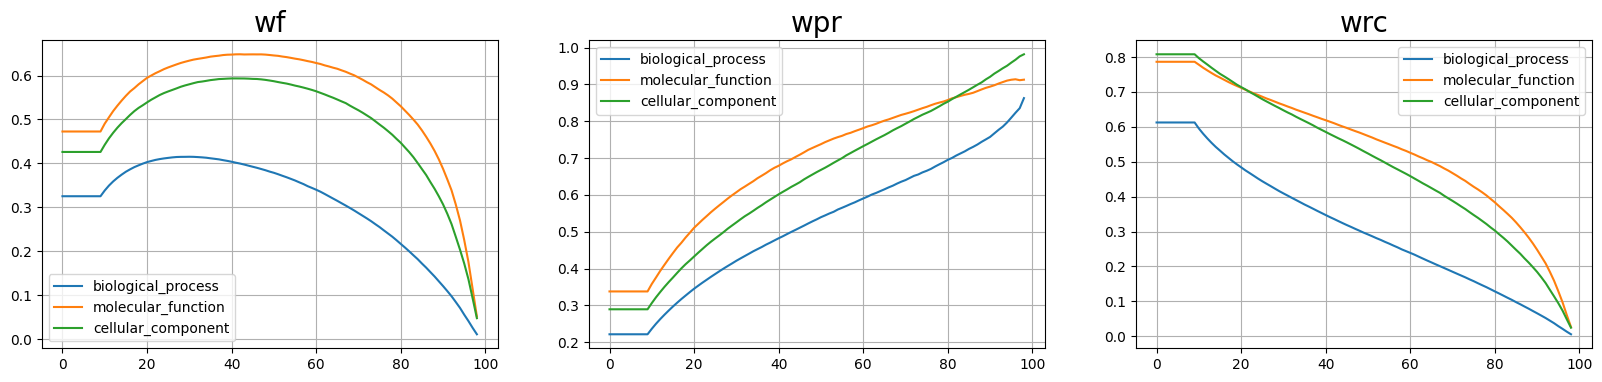

Scores:  {'F1w': 0.552276, 'F1 CCO': 0.593388, 'F1 BPO': 0.415089, 'F1 MFO': 0.648352, 'thres CCO': 0.42000000000000004, 'thres BPO': 0.31, 'thres MFO': 0.43, 'F-Scores Time': 606.2}
CAFA-F1 scoring fold 0 finished. Model Final1 Blend
Available RAM: 708.60 G  Current datetime: 2024-05-30 17:41:32.674293
Scoring starts. n_samples: 28449
save valid.csv 1.0
gt_parser 33.4
create preds 348.4
pred_parser 186.9 len(preds) 3
evaluate_prediction 31.9 got df_metrics with shape: (297, 12)


,cov,pr,rc,wpr,wrc,ru,mi,ns,tau,f,wf,s
0,1.0,0.0,0.0,0.231256,0.604088,0.0,0.0,biological_process,0.01,0.0,0.334471,0.0
1,1.0,0.0,0.0,0.231256,0.604088,0.0,0.0,biological_process,0.02,0.0,0.334471,0.0


,wf
ns,
biological_process,0.414129
cellular_component,0.591956
molecular_function,0.654061


wf    0.553382
dtype: float64
F1-scoring finished. 601.9 secs passed


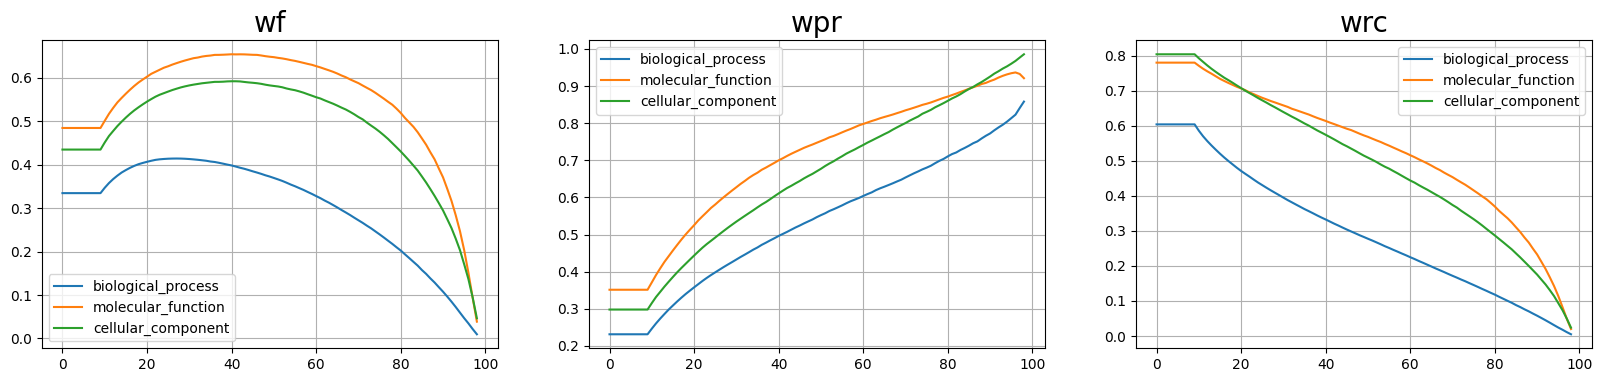

Scores:  {'F1w': 0.553382, 'F1 CCO': 0.591956, 'F1 BPO': 0.414129, 'F1 MFO': 0.654061, 'thres CCO': 0.41000000000000003, 'thres BPO': 0.28, 'thres MFO': 0.41000000000000003, 'F-Scores Time': 602.3}
CAFA-F1 scoring fold 1 finished. Model Final1 Blend
Available RAM: 714.84 G  Current datetime: 2024-05-30 17:55:39.701099
Scoring starts. n_samples: 28458
save valid.csv 0.9
gt_parser 33.2


In [ ]:
%%time
import gc 
import time 
import datetime
log_available_ram('Before modeling')

######################### Params ##################################################3

if 0: 
    mode_submit = True 
verbose = 0


######################### Output ##################################################
df_stat = pd.DataFrame()

if (mode_submit is not None) and ( mode_submit != False ):
    Y_submit = np.zeros( (141865, Y.shape[1] )  , dtype = np.float16 )  # Predictions for submission will be stored here 
    # Results from all models and all folds will be blended 
    print('Y_submit mbytes:', Y_submit.nbytes/1024/1024)
cnt_blend_submit = 0 ;  

if  flag_compute_oof_predictions:
    Y_pred_oof_blend  = np.zeros( ( Y.shape )  , dtype = np.float16 )
    print('Y_pred_oof_blend mbytes:', Y_pred_oof_blend.nbytes/1024/1024)
cnt_blend_oof = -1;


########################## Preparations ###########################################
log_available_ram('Right before modeling')

if flag_compute_stat_for_each_model:  # Predictions OOF for each particular model - will be rewritten for each modelling 
    Y_pred_oof = np.zeros( ( Y.shape )  , dtype = np.float16 )
    print('Y_pred_oof mbytes:', Y_pred_oof.nbytes/1024/1024)

i_model = -1 # 
i_config = -1 # conter for configurations 
t0modeling = time.time()
list_folds_ix =  np.sort(list ( set(folds))  )
print(); print('Start training models',datetime.datetime.now()) ; print()
########################## Main modelling  ###########################################
for main_config_model_feature_etc  in list_main_config_model_feature_etc:
    i_config += 1 
    model_config = main_config_model_feature_etc['model']
    print('model_config.keys() ==== ',model_config.keys())
    if ('Keras' in model_config.keys() ) and ( model_config['Keras'] ): continue   # Keras models will be processed in the next cell - RAM leak problem
    if 'list_features_id' in main_config_model_feature_etc.keys():
        print()
        X,vec_train_protein_ids,X_submit,  submit_protein_ids = get_features(main_config_model_feature_etc['list_features_id'], verbose = 100)
        gc.collect()
        log_available_ram(f"New features loaded:  {str(main_config_model_feature_etc['list_features_id'])}" )  
        print()
        
    mode_downsample_train = model_config.get('mode_downsample_train', mode_downsample_train_default)
    
    n_selfblend = model_config.get( 'n_selfblend' , 1)
    if verbose >= 100:
        print(); print('Starting model_config:', model_config, f'time from start: {(time.time() - t0modeling ):.1f}' )
    for i_selfblend in range( n_selfblend ): # train-predict same model several times and blend predictions - especially useful for NN, but do not fix random seed (!)
        i_model += 1 # Models count
        t0one_model_all_folds = time.time()
        for ix_fold  in  list_folds_ix[:n_folds_to_process]:
        
            model, str_model_id = get_model(model_config)
            str_model_id_pure_save =  str_model_id
            str_model_id = str( i_model) + ' ' + str_model_id
            if n_selfblend > 1:  str_model_id += ' ' + str( i_selfblend )

            ##################### Prepare train data ###################################################
            mask_fold = folds == ix_fold
            IX_train = np.where(mask_fold ==  0)[0]; 
            IX_train = get_downsampled_IX_train(IX_train, mode_downsample_train )
            X_train = X[IX_train,:]; Y_train = Y[IX_train,:]

            if verbose >= 10:
                print(f'fold {ix_fold}, model: {str_model_id},  X_train.shape: {X_train.shape}, Y_train.shape: {Y_train.shape}, time: { (time.time() - t0modeling):12.1f} ')
                print('X_train Mbytes:', X_train.nbytes/1024/1024, 'Y_train Mbytes:', Y_train.nbytes/1024/1024,  )
            ##################### Call train model ###################################################
            t0 = time.time()
            model_fit(model , X_train, Y_train, model_config , str_model_id, verbose = 0 )   
            time_fit = time.time() - t0
            if verbose >= 1000:
                print(f'time_fit {time_fit:.1f}' ) 
            del X_train, Y_train
            torch.cuda.empty_cache()
            gc.collect()
            log_available_ram(f'After Model fit. ix_fold {ix_fold}, i_selfblend, {i_selfblend}, {str_model_id}')
            
            ##################### Compute predictions for submission and blend with the previous one ###################################################
            if  mode_submit : 
                t0 = time.time()
                Y_submit = (Y_submit * cnt_blend_submit  + model_predict(model , X_submit,  model_config , str_model_id , verbose = 0 ) )/ (cnt_blend_submit + 1);  # Average predictions from different folds/models
                cnt_blend_submit += 1 
                time_pred_submit = time.time() - t0
                torch.cuda.empty_cache()
                gc.collect()

            #flag_compute_oof_predictions = True                 
            if  flag_compute_oof_predictions:
                t0 = time.time()
                IX_val = np.where(mask_fold > 0 )[0]; 
                X_val = X[IX_val,:];#  Y_val = Y[IX_val,:]
                Y_pred_val = model_predict(model , X_val,  model_config , str_model_id , verbose = 0 )
                time_pred_val = time.time() - t0
                if verbose >= 10000:
                    print('Y_pred_val.shape', Y_pred_val.shape, f'time_pred_val {time_pred_val:.1f}')
                    
                if ix_fold == 0: cnt_blend_oof += 1 
                Y_pred_oof_blend[IX_val,:] = (Y_pred_oof_blend[IX_val,:] * cnt_blend_oof  + Y_pred_val )/ (cnt_blend_oof + 1); 
            
                if  flag_compute_stat_for_each_model:
                    Y_pred_oof[IX_val,:] = (Y_pred_val ) 
                    
                del X_val, Y_pred_val                    
                torch.cuda.empty_cache()
                gc.collect()
                
            del model 
            torch.cuda.empty_cache()
            gc.collect()
            log_available_ram(f'At fold end. Model {str_model_id}, i_selfblend {i_selfblend}, fold {ix_fold} ')

        time_one_model = np.round( time.time() - t0one_model_all_folds )
        if flag_compute_stat_for_each_model and flag_compute_oof_predictions: 
            update_modeling_stat(df_stat, Y_pred_oof,  Y, flag_compute_cafa_f1 = flag_compute_cafa_f1_for_each_model , 
                                 str_model_id = str_model_id, dict_optional_info = {'Time': time_one_model , 'i_selfblend':i_selfblend,
                                'ModelID Pure':str_model_id_pure_save, 'i_config':i_config}, verbose = 0)
            torch.cuda.empty_cache()
            gc.collect()
            log_available_ram(f'After OOF-Stat Calculation. Model {str_model_id}, i_selfblend {i_selfblend}' )
            
        if flag_compute_each_blend_stat and flag_compute_oof_predictions:
            update_modeling_stat(df_stat, Y_pred_oof_blend,  Y, flag_compute_cafa_f1 = flag_compute_cafa_f1_for_each_blend , 
                                 str_model_id = str(cnt_blend_oof )+ 'Blend'+ ' ' +str_model_id, dict_optional_info = {'Time': time_one_model, 
                                        'Blend': cnt_blend_oof , 'i_selfblend':i_selfblend}, verbose = 0)
            torch.cuda.empty_cache()
            gc.collect()
            log_available_ram(f'After Blend-Stat Calculation. Model {str_model_id}, i_selfblend {i_selfblend}' )
                
if flag_save_numpy_Y_pred_oof_blend and flag_compute_oof_predictions:
    t0 = time.time()
    fn = 'Y_pred_oof_blend.npy'
    np.save(fn,Y_pred_oof_blend)
    print(f'File {fn} saved. Y_pred_oof_blend.shape: {Y_pred_oof_blend.shape}. Time: {(time.time()-t0):.1f}')
    t0 = time.time()
    fn = 'Y_labels.npy'
    np.save(fn,Y_labels)
    print(f'File {fn} saved. Time: {(time.time()-t0):.1f}')

if flag_save_numpy_Y_submit and mode_submit:
    t0 = time.time()
    fn = 'Y_submit.npy'
    np.save(fn,Y_submit)
    print(f'File {fn} saved. Y_submit.shape: {Y_submit.shape}. Time: {(time.time()-t0):.1f}')
    t0 = time.time()
    fn = 'Y_labels.npy'
    np.save(fn,Y_labels)
    print(f'File {fn} saved. Time: {(time.time()-t0):.1f}')


if flag_compute_final_model_stat and  flag_compute_oof_predictions:  
    update_modeling_stat(df_stat, Y_pred_oof_blend,  Y, flag_compute_cafa_f1 = True , str_model_id= 'Final1 Blend', dict_optional_info = { }, verbose = 0)
    gc.collect()
    log_available_ram('After Final Stat Calculation')
            
display(df_stat)   

print('%.1f seconds passed total '%(time.time()-t0start) )
log_available_ram('After Modelling 1 Finished')

## Modeling specific to Keras models

Keras models leak RAM in the code above - so here we try to create a specific  code 
for modelling with Keras 

The cell below is almost same as the one above, but we simplify things specifically to Keras models setup

That is not intended technical modifaction - if we will find the ways to avoid memory leak in Keras models will return to uniform code as in the previous cell. 


Scoring starts. n_samples: 28442
save valid.csv 0.9
gt_parser 33.5
create preds 349.4
pred_parser 190.0 len(preds) 3
evaluate_prediction 31.4 got df_metrics with shape: (297, 12)


,cov,pr,rc,wpr,wrc,ru,mi,ns,tau,f,wf,s
0,1.0,0.0,0.0,0.221412,0.61246,0.0,0.0,biological_process,0.01,0.0,0.325244,0.0
1,1.0,0.0,0.0,0.221412,0.61246,0.0,0.0,biological_process,0.02,0.0,0.325244,0.0


,wf
ns,
biological_process,0.415089
cellular_component,0.593388
molecular_function,0.648352


wf    0.552276
dtype: float64
F1-scoring finished. 605.6 secs passed


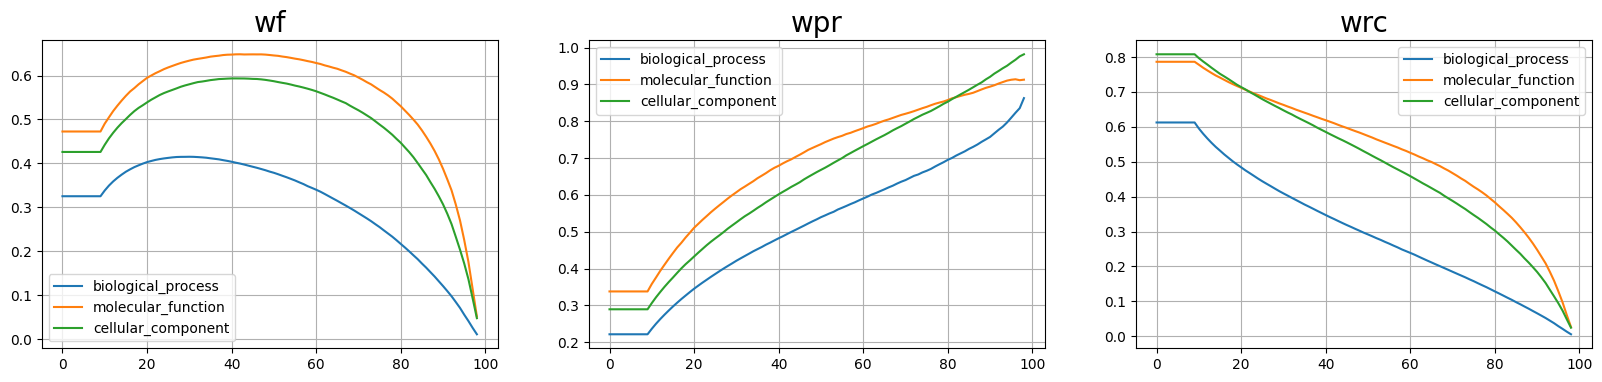

Scores:  {'F1w': 0.552276, 'F1 CCO': 0.593388, 'F1 BPO': 0.415089, 'F1 MFO': 0.648352, 'thres CCO': 0.42000000000000004, 'thres BPO': 0.31, 'thres MFO': 0.43, 'F-Scores Time': 606.0}
CAFA-F1 scoring fold 0 finished. Model FinalKeras Blend
Available RAM: 717.64 G  Current datetime: 2024-05-30 18:52:38.040309
Scoring starts. n_samples: 28449
save valid.csv 1.0
gt_parser 34.5
create preds 347.2
pred_parser 188.8 len(preds) 3
evaluate_prediction 31.8 got df_metrics with shape: (297, 12)


,cov,pr,rc,wpr,wrc,ru,mi,ns,tau,f,wf,s
0,1.0,0.0,0.0,0.231256,0.604088,0.0,0.0,biological_process,0.01,0.0,0.334471,0.0
1,1.0,0.0,0.0,0.231256,0.604088,0.0,0.0,biological_process,0.02,0.0,0.334471,0.0


,wf
ns,
biological_process,0.414129
cellular_component,0.591956
molecular_function,0.654061


wf    0.553382
dtype: float64
F1-scoring finished. 603.6 secs passed


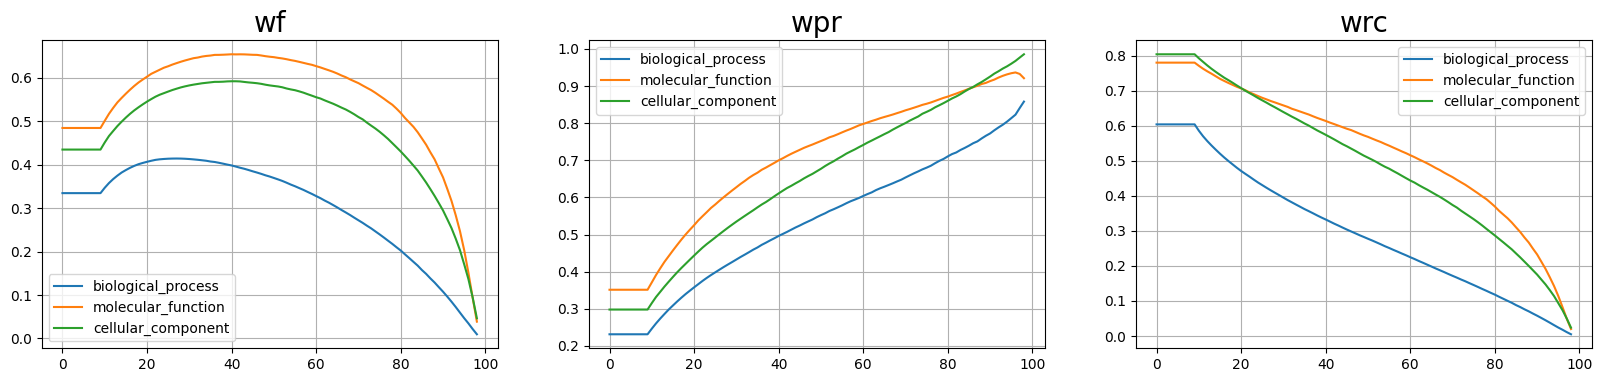

Scores:  {'F1w': 0.553382, 'F1 CCO': 0.591956, 'F1 BPO': 0.414129, 'F1 MFO': 0.654061, 'thres CCO': 0.41000000000000003, 'thres BPO': 0.28, 'thres MFO': 0.41000000000000003, 'F-Scores Time': 604.0}
CAFA-F1 scoring fold 1 finished. Model FinalKeras Blend
Available RAM: 728.35 G  Current datetime: 2024-05-30 19:06:50.405289
Scoring starts. n_samples: 28458
save valid.csv 1.0
gt_parser 33.3
create preds 347.9
pred_parser 182.3 len(preds) 3
evaluate_prediction 32.0 got df_metrics with shape: (297, 12)


,cov,pr,rc,wpr,wrc,ru,mi,ns,tau,f,wf,s
0,1.0,0.0,0.0,0.238317,0.597578,0.0,0.0,biological_process,0.01,0.0,0.340744,0.0
1,1.0,0.0,0.0,0.238317,0.597578,0.0,0.0,biological_process,0.02,0.0,0.340744,0.0


,wf
ns,
biological_process,0.414808
cellular_component,0.587519
molecular_function,0.655239


wf    0.552522
dtype: float64
F1-scoring finished. 596.9 secs passed


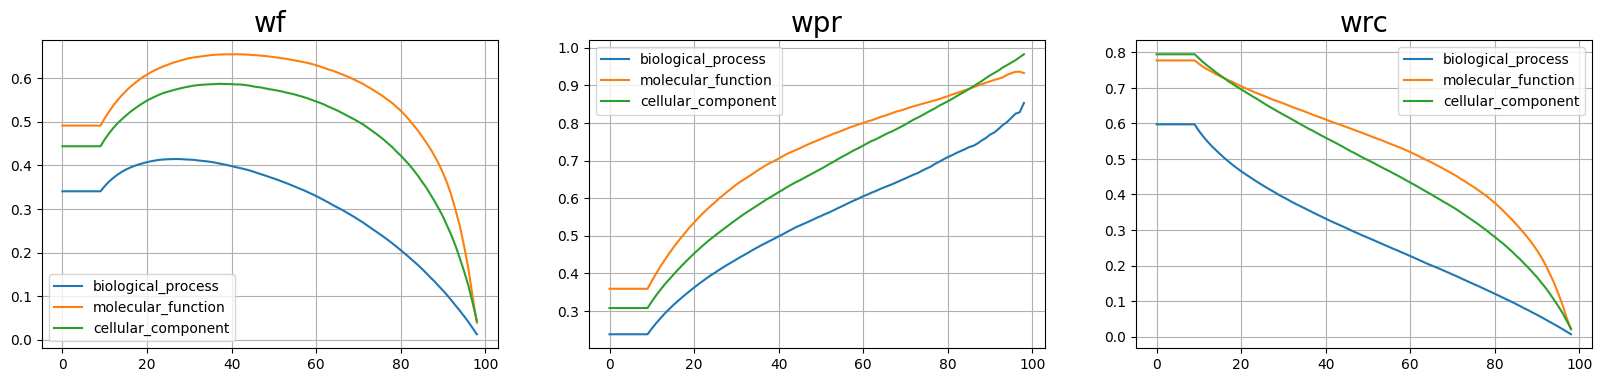

Scores:  {'F1w': 0.552522, 'F1 CCO': 0.587519, 'F1 BPO': 0.414808, 'F1 MFO': 0.655239, 'thres CCO': 0.38, 'thres BPO': 0.28, 'thres MFO': 0.42000000000000004, 'F-Scores Time': 597.3}
CAFA-F1 scoring fold 2 finished. Model FinalKeras Blend
Available RAM: 713.03 G  Current datetime: 2024-05-30 19:20:52.046911
Scoring starts. n_samples: 28467
save valid.csv 1.0
gt_parser 34.0
create preds 349.5
pred_parser 186.7 len(preds) 3
evaluate_prediction 31.3 got df_metrics with shape: (297, 12)


,cov,pr,rc,wpr,wrc,ru,mi,ns,tau,f,wf,s
0,1.0,0.0,0.0,0.224243,0.60426,0.0,0.0,biological_process,0.01,0.0,0.327099,0.0
1,1.0,0.0,0.0,0.224243,0.60426,0.0,0.0,biological_process,0.02,0.0,0.327099,0.0


,wf
ns,
biological_process,0.412862
cellular_component,0.591699
molecular_function,0.650632


wf    0.551731
dtype: float64
F1-scoring finished. 602.8 secs passed


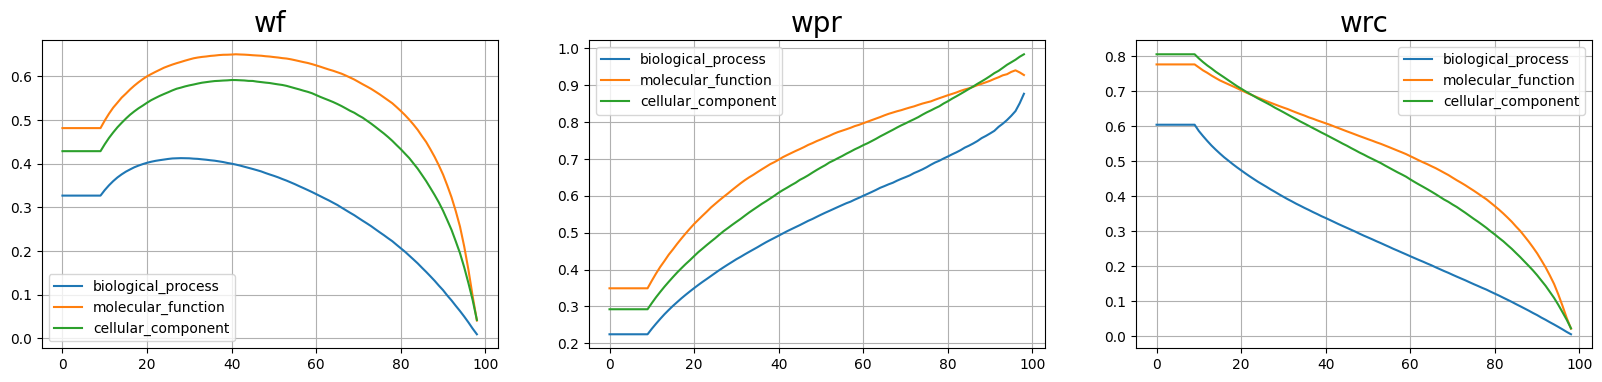

Scores:  {'F1w': 0.551731, 'F1 CCO': 0.591699, 'F1 BPO': 0.412862, 'F1 MFO': 0.650632, 'thres CCO': 0.41000000000000003, 'thres BPO': 0.29000000000000004, 'thres MFO': 0.42000000000000004, 'F-Scores Time': 603.2}
CAFA-F1 scoring fold 3 finished. Model FinalKeras Blend
Available RAM: 707.06 G  Current datetime: 2024-05-30 19:34:59.938797
Scoring starts. n_samples: 28430
save valid.csv 1.0
gt_parser 34.0
create preds 348.2
pred_parser 188.8 len(preds) 3
evaluate_prediction 30.7 got df_metrics with shape: (297, 12)


,cov,pr,rc,wpr,wrc,ru,mi,ns,tau,f,wf,s
0,1.0,0.0,0.0,0.224509,0.610345,0.0,0.0,biological_process,0.01,0.0,0.328268,0.0
1,1.0,0.0,0.0,0.224509,0.610345,0.0,0.0,biological_process,0.02,0.0,0.328268,0.0


,wf
ns,
biological_process,0.419184
cellular_component,0.595023
molecular_function,0.654952


wf    0.556386
dtype: float64
F1-scoring finished. 603.0 secs passed


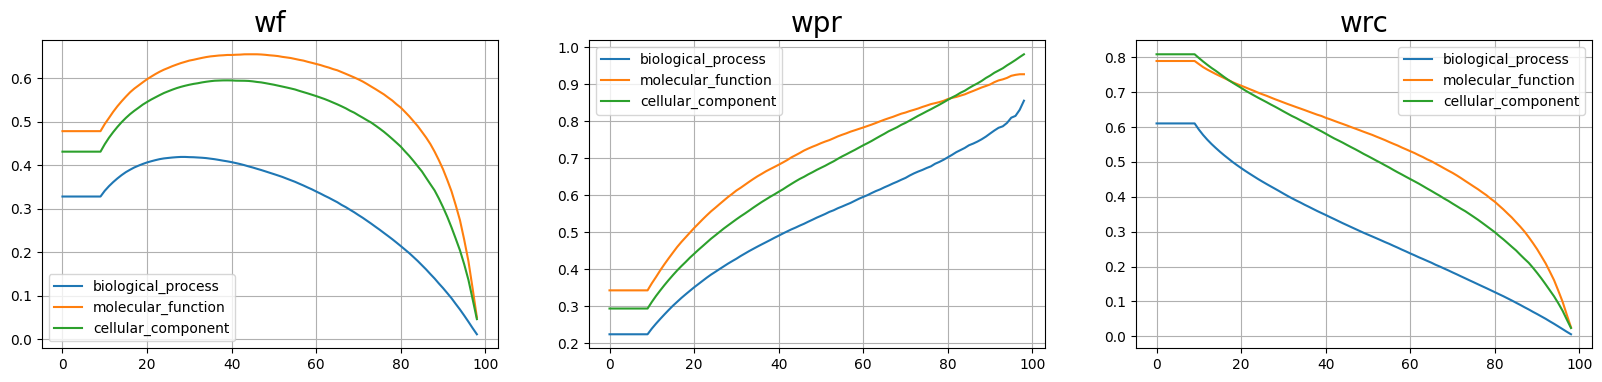

Scores:  {'F1w': 0.556386, 'F1 CCO': 0.595023, 'F1 BPO': 0.419184, 'F1 MFO': 0.654952, 'thres CCO': 0.4, 'thres BPO': 0.29000000000000004, 'thres MFO': 0.46, 'F-Scores Time': 603.3}
CAFA-F1 scoring fold 4 finished. Model FinalKeras Blend
Available RAM: 726.13 G  Current datetime: 2024-05-30 19:49:04.827102
After Final Stat Calculation
Available RAM: 720.20 G  Current datetime: 2024-05-30 19:49:05.370573


,Model,Fold,AUC,F1w,F1 CCO,F1 BPO,F1 MFO,thres CCO,thres BPO,thres MFO,F-Scores Time,GE0.2 per prot,GE0.3 per prot,GE0.4 per prot,GE0.5 per prot,n_targets,n_samples Val,Time scoring,Features,Model Features
1,Final1 Blend,0.0,0.96390,0.552276,0.593388,0.415089,0.648352,0.42,0.31,0.43,606.2,80.0,59.0,46.0,36.0,10000.0,142246.0,844.7,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
2,Final1 Blend,1.0,0.96365,0.553382,0.591956,0.414129,0.654061,0.41,0.28,0.41,602.3,80.0,59.0,46.0,36.0,10000.0,142246.0,846.7,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
3,Final1 Blend,2.0,0.96309,0.552522,0.587519,0.414808,0.655239,0.38,0.28,0.42,596.0,80.0,59.0,46.0,36.0,10000.0,142246.0,843.9,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
4,Final1 Blend,3.0,0.96363,0.551731,0.591699,0.412862,0.650632,0.41,0.29,0.42,607.5,80.0,59.0,46.0,36.0,10000.0,142246.0,855.9,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
5,Final1 Blend,4.0,0.96293,0.556386,0.595023,0.419184,0.654952,0.40,0.29,0.46,608.7,80.0,59.0,46.0,36.0,10000.0,142246.0,858.2,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
6,FinalKeras Blend,0.0,0.96390,0.552276,0.593388,0.415089,0.648352,0.42,0.31,0.43,606.0,80.0,59.0,46.0,36.0,10000.0,142246.0,852.8,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
7,FinalKeras Blend,1.0,0.96365,0.553382,0.591956,0.414129,0.654061,0.41,0.28,0.41,604.0,80.0,59.0,46.0,36.0,10000.0,142246.0,852.1,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
8,FinalKeras Blend,2.0,0.96309,0.552522,0.587519,0.414808,0.655239,0.38,0.28,0.42,597.3,80.0,59.0,46.0,36.0,10000.0,142246.0,841.4,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
9,FinalKeras Blend,3.0,0.96363,0.551731,0.591699,0.412862,0.650632,0.41,0.29,0.42,603.2,80.0,59.0,46.0,36.0,10000.0,142246.0,847.6,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
10,FinalKeras Blend,4.0,0.96293,0.556386,0.595023,0.419184,0.654952,0.40,0.29,0.46,603.3,80.0,59.0,46.0,36.0,10000.0,142246.0,844.6,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"


After Modelling Keras Finished
Available RAM: 718.51 G  Current datetime: 2024-05-30 19:49:05.603780
CPU times: user 1h 6min 51s, sys: 3min 58s, total: 1h 10min 49s
Wall time: 1h 10min 46s


In [14]:
%%time
######################### Params ##################################################3

verbose = 1000

######################### Output ##################################################

########################## Preparations ###########################################
log_available_ram('Right before Keras modeling')


t0modeling = time.time()
list_folds_ix =  np.sort(list ( set(folds))  )
print(); print('Start training Keras models',datetime.datetime.now()) ; print()
########################## Main modelling  ###########################################
for main_config_model_feature_etc  in list_main_config_model_feature_etc:
    model_config = main_config_model_feature_etc['model']
    if 'Keras' not in model_config.keys(): continue  
    if  model_config['Keras'] == False : continue  
    if 'list_features_id' in main_config_model_feature_etc.keys():
        print()
        X,vec_train_protein_ids,X_submit,  submit_protein_ids = get_features(main_config_model_feature_etc['list_features_id'], verbose = 100)
        gc.collect()
        log_available_ram(f"New features loaded:  {str(main_config_model_feature_etc['list_features_id'])}" )  
        print()
    
    mode_downsample_train = model_config.get('mode_downsample_train', mode_downsample_train_default)
        
    n_selfblend = model_config.get( 'n_selfblend' , 1)
    if verbose >= 100:
        print(); print('Starting model_config:', model_config, f'time from start: {(time.time() - t0modeling ):.1f}' )
    for i_selfblend in range( n_selfblend ): # train-predict same model several times and blend predictions - especially useful for NN, but do not fix random seed (!)
        i_model += 1 # Models count
        t0one_model_all_folds = time.time()
        for ix_fold  in  list_folds_ix[:n_folds_to_process]:
            if verbose >= 10: 
                print('---------------------------------------------- Fold', ix_fold, '----------------------------------------------')
                
            model, str_model_id = get_model(model_config)
            str_model_id_pure_save = str_model_id
            log_available_ram(f'After Keras model init. ix_fold {ix_fold}, n_selfblend, {n_selfblend}, {str_model_id}')
            str_model_id = str( i_model) + ' ' + str_model_id
            if n_selfblend > 1:  str_model_id += ' ' + str( i_selfblend )
                
            ##################### Prepare train data ###################################################
            mask_fold = folds == ix_fold
            IX_train = np.where(mask_fold ==  0)[0]; 
            # IX_train = [ix for ix in IX_train if ix in  set_allowed_train_indexes]
            IX_train = get_downsampled_IX_train(IX_train, mode_downsample_train )

            #X_train = X[IX_train,:]; Y_train = Y[IX_train,:]
            log_available_ram(f'After setting X_train. ix_fold {ix_fold}, n_selfblend, {n_selfblend}, {str_model_id}')

            if verbose >= 10:
                print(f'fold {ix_fold}, model: {str_model_id},  X_train.shape: {X[IX_train,:].shape}, Y_train.shape: {Y[IX_train,:].shape}, time: { (time.time() - t0modeling):12.1f} ')

            ##################### Call train model ###################################################
            t0 = time.time()
            #model_fit(model , X_train, Y_train, model_config , str_model_id, verbose = 0 )   
            epochs = model_config.get( 'epochs' , 15)
            batch_size = model_config.get( 'batch_size' , 128 )
            model.fit( X[IX_train,:], Y[IX_train,:] ,epochs = epochs,   batch_size = batch_size, verbose = 0  )
            time_fit = time.time() - t0
            if verbose >= 1000:
                print(f'time_fit {time_fit:.1f}' ) 
            #del X_train, Y_train
            torch.cuda.empty_cache()
            gc.collect()
            log_available_ram(f'After Model fit. ix_fold {ix_fold}, i_selfblend, {i_selfblend}, {str_model_id}')
            
            ##################### Compute predictions for submission and blend with the previous one ###################################################
            if  mode_submit : 
                t0 = time.time()
                Y_submit = (Y_submit * cnt_blend_submit  + model_predict(model , X_submit,  model_config , str_model_id , verbose = 0 ) )/ (cnt_blend_submit + 1);  # Average predictions from different folds/models
                cnt_blend_submit += 1 
                time_pred_submit = time.time() - t0
                torch.cuda.empty_cache()
                gc.collect()
                log_available_ram(f'After Predict on submit. ix_fold {ix_fold}, i_selfblend, {i_selfblend}, {str_model_id}')
                
            #flag_compute_oof_predictions = True                 
            if  flag_compute_oof_predictions:
                t0 = time.time()
                IX_val = np.where(mask_fold > 0 )[0]; 
                #X_val = X[IX_val,:];#  Y_val = Y[IX_val,:]
                Y_pred_val = model_predict(model , X[IX_val,:],  model_config , str_model_id , verbose = 0 )
                time_pred_val = time.time() - t0
                if verbose >= 10000:
                    print('Y_pred_val.shape', Y_pred_val.shape, f'time_pred_val {time_pred_val:.1f}')
                if ix_fold == 0: cnt_blend_oof += 1 
                Y_pred_oof_blend[IX_val,:] = (Y_pred_oof_blend[IX_val,:] * cnt_blend_oof  + Y_pred_val )/ (cnt_blend_oof + 1); 
            
                if  flag_compute_stat_for_each_model:
                    Y_pred_oof[IX_val,:] = (Y_pred_val ) 
                    
                del  Y_pred_val                    
                torch.cuda.empty_cache()
                gc.collect()
                log_available_ram(f'After Predict on OOF. ix_fold {ix_fold}, i_selfblend, {i_selfblend}, {str_model_id}')
            
            keras.backend.clear_session()
            del model
            gc.collect()
            keras.backend.clear_session()
            torch.cuda.empty_cache()
            gc.collect()
            log_available_ram(f'At fold end. Model {str_model_id}, i_selfblend {i_selfblend}, fold {ix_fold} ')

        time_one_model = np.round( time.time() - t0one_model_all_folds )
        if flag_compute_stat_for_each_model and flag_compute_oof_predictions: 
            update_modeling_stat(df_stat, Y_pred_oof,  Y, flag_compute_cafa_f1 = flag_compute_cafa_f1_for_each_model , 
                 str_model_id = str_model_id, dict_optional_info = {'Time': time_one_model, 
                'i_selfblend':i_selfblend, 'ModelID Pure':str_model_id_pure_save, 'i_config':i_config }, verbose = 0)
            torch.cuda.empty_cache()
            gc.collect()
            log_available_ram(f'After OOF-Stat Calculation. Model {str_model_id}, i_selfblend {i_selfblend}' )
            
        if flag_compute_each_blend_stat and flag_compute_oof_predictions:
            update_modeling_stat(df_stat, Y_pred_oof_blend,  Y, flag_compute_cafa_f1 = flag_compute_cafa_f1_for_each_blend , 
                                 str_model_id = str(cnt_blend_oof )+ 'Blend'+ ' ' +str_model_id, dict_optional_info = {'Time': time_one_model, 
                                'Blend': cnt_blend_oof, 'i_selfblend':i_selfblend}, verbose = 0)
            torch.cuda.empty_cache()
            gc.collect()
            log_available_ram(f'After Blend-Stat Calculation. Model {str_model_id}, i_selfblend {i_selfblend}' )
                
if flag_save_numpy_Y_pred_oof_blend and flag_compute_oof_predictions:
    t0 = time.time()
    fn = 'Y_pred_oof_blend.npy'
    np.save(fn,Y_pred_oof_blend)
    print(f'File {fn} saved. Y_pred_oof_blend.shape: {Y_pred_oof_blend.shape}. Time: {(time.time()-t0):.1f}')
    t0 = time.time()
    fn = 'Y_labels.npy'
    np.save(fn,Y_labels)
    print(f'File {fn} saved. Time: {(time.time()-t0):.1f}')

if flag_save_numpy_Y_submit and mode_submit:
    t0 = time.time()
    fn = 'Y_submit.npy'
    np.save(fn,Y_submit)
    print(f'File {fn} saved. Y_submit.shape: {Y_submit.shape}. Time: {(time.time()-t0):.1f}')
    t0 = time.time()
    fn = 'Y_labels.npy'
    np.save(fn,Y_labels)
    print(f'File {fn} saved. Time: {(time.time()-t0):.1f}')
    log_available_ram(f'After Save Y_submit' )


if flag_compute_final_model_stat and  flag_compute_oof_predictions:  
    #time_one_model = np.round( time.time() - t0one_model_all_folds )
    update_modeling_stat(df_stat, Y_pred_oof_blend,  Y, flag_compute_cafa_f1 = True , str_model_id= 'FinalKeras Blend', dict_optional_info = { }, verbose = 0)
    gc.collect()
    log_available_ram('After Final Stat Calculation')
            
display(df_stat)            

if flag_compute_stat_for_each_model: 
    del Y_pred_oof
    
torch.cuda.empty_cache()    
gc.collect()

log_available_ram('After Modelling Keras Finished')

# Show/plot modelling results 

In [15]:
if ('AUC' in df_stat.columns) and ( 'F1w' in df_stat.columns ):
    print(); print('Pearson correlations:')
    display( df_stat[['AUC','F1w']].corr() )
    
    print(); print('Spearman correlations:')
    display( df_stat[['AUC','F1w']].corr(method = 'spearman') )

print(df_stat.shape)
display( df_stat )


Pearson correlations:


,AUC,F1w
AUC,1.000000,-0.677121
F1w,-0.677121,1.000000



Spearman correlations:


,AUC,F1w
AUC,1.0,-0.5
F1w,-0.5,1.0


(10, 20)


,Model,Fold,AUC,F1w,F1 CCO,F1 BPO,F1 MFO,thres CCO,thres BPO,thres MFO,F-Scores Time,GE0.2 per prot,GE0.3 per prot,GE0.4 per prot,GE0.5 per prot,n_targets,n_samples Val,Time scoring,Features,Model Features
1,Final1 Blend,0.0,0.96390,0.552276,0.593388,0.415089,0.648352,0.42,0.31,0.43,606.2,80.0,59.0,46.0,36.0,10000.0,142246.0,844.7,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
2,Final1 Blend,1.0,0.96365,0.553382,0.591956,0.414129,0.654061,0.41,0.28,0.41,602.3,80.0,59.0,46.0,36.0,10000.0,142246.0,846.7,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
3,Final1 Blend,2.0,0.96309,0.552522,0.587519,0.414808,0.655239,0.38,0.28,0.42,596.0,80.0,59.0,46.0,36.0,10000.0,142246.0,843.9,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
4,Final1 Blend,3.0,0.96363,0.551731,0.591699,0.412862,0.650632,0.41,0.29,0.42,607.5,80.0,59.0,46.0,36.0,10000.0,142246.0,855.9,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
5,Final1 Blend,4.0,0.96293,0.556386,0.595023,0.419184,0.654952,0.40,0.29,0.46,608.7,80.0,59.0,46.0,36.0,10000.0,142246.0,858.2,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
6,FinalKeras Blend,0.0,0.96390,0.552276,0.593388,0.415089,0.648352,0.42,0.31,0.43,606.0,80.0,59.0,46.0,36.0,10000.0,142246.0,852.8,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
7,FinalKeras Blend,1.0,0.96365,0.553382,0.591956,0.414129,0.654061,0.41,0.28,0.41,604.0,80.0,59.0,46.0,36.0,10000.0,142246.0,852.1,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
8,FinalKeras Blend,2.0,0.96309,0.552522,0.587519,0.414808,0.655239,0.38,0.28,0.42,597.3,80.0,59.0,46.0,36.0,10000.0,142246.0,841.4,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
9,FinalKeras Blend,3.0,0.96363,0.551731,0.591699,0.412862,0.650632,0.41,0.29,0.42,603.2,80.0,59.0,46.0,36.0,10000.0,142246.0,847.6,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"
10,FinalKeras Blend,4.0,0.96293,0.556386,0.595023,0.419184,0.654952,0.40,0.29,0.46,603.3,80.0,59.0,46.0,36.0,10000.0,142246.0,844.6,"['t5', 'esm2S1280']","Blend ['t5', 'esm2S1280']"


# Prepare submission

In [ ]:
%%time
import gc
if 0:
    del X_train,Y_train, X_val, Y_val, train_dataset, train_dataloader, X, Y
gc.collect()
torch.cuda.empty_cache()

log_available_ram()

Available RAM: 717.45 G  Current datetime: 2024-05-30 19:49:06.006414
CPU times: user 218 ms, sys: 87 µs, total: 218 ms
Wall time: 216 ms


## Prepare submission tsv file

In [ ]:
%%time

mode_submit_prepare = 'slow_less_RAM_consuming'
# 'slow_less_RAM_consuming' - works slower but consumes less RAM

import time 
t0 = time.time()

print( mode_submit_prepare , mode_submit)
if (mode_submit ) and ( flag_save_final_submit_file ):
    print(Y_submit.shape)
    if mode_submit_prepare == 'slow_less_RAM_consuming':


        file_path = "submission.tsv"
        cc = 0
        cc2 = 0
        with open(file_path, 'w') as file:
            for i in range(Y_submit.shape[0]):
                for j in range(Y_submit.shape[1]):
                    val = Y_submit[i,j]
                    if val >= cutoff_threshold_low:
                        str_go_term = str(Y_labels[j])
                        str_protein_id = str( submit_protein_ids[i] )
                        str_save = str_protein_id+'\t'+str_go_term + '\t' + '%.3f'%val + '\n'
                        file.write(str_save)   
                        cc2 +=1
                        if cc2 <= 10:
                            if cc2 == 1: print('First 10 examples of the saved data:')
                            print(str_save)
                    cc += 1
                    if cc % 30_000_000  == 0: 
                        sz = Y_submit.shape[0]*Y_submit.shape[1]
                        print(cc, 'out of',sz, 'percent %.2f'%(cc/sz*100), 'saved:'  ,cc2, 'time %.1f'%(time.time() - t0 ))

        print(cc2,'results saved to submission file', 'time  %.1f'%(time.time() - t0 )  )                

    else:

        # That is widely used way to preparase submission , but it might crash by RAM 

        df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])

        n_targets_predicted = Y_submit.shape[1]
        n_samples_predicted = Y_submit.shape[0]
        print('n_samples_predicted, n_targets_predicted',  n_samples_predicted, n_targets_predicted )


        protein_list = []
        for k in list(submit_protein_ids):
            protein_list += [k] * n_targets_predicted
        df_submission['Protein Id'] = protein_list

        df_submission['GO Term Id'] = list(Y_labels) * n_samples_predicted
        df_submission['Prediction'] = Y_submit.ravel()

        df_submission = df_submission.round(3)
        df_submission = df_submission[ df_submission['Prediction'] >= cutoff_threshold_low  ]

        memory_usage_per_column = df_submission.memory_usage(deep=True)
        total_memory_usage = memory_usage_per_column.sum()
        print("\nTotal memory usage:", total_memory_usage/1e6, "Megabytes")

        print(df_submission.shape)
        display(df_submission)

        import gc
        if 0:
            del preds 

        gc.collect()

        df_submission.to_csv("submission.tsv",header=False, index=False,sep='\t')


    log_available_ram('After saving submission')    

slow_less_RAM_consuming True
(141865, 10000)
First 10 examples of the saved data:
Q9CQV8	GO:0005575	1.000

Q9CQV8	GO:0008150	1.000

Q9CQV8	GO:0110165	0.998

Q9CQV8	GO:0003674	1.000

Q9CQV8	GO:0005622	0.945

Q9CQV8	GO:0009987	0.771

Q9CQV8	GO:0043226	0.798

Q9CQV8	GO:0043229	0.658

Q9CQV8	GO:0005488	0.969

Q9CQV8	GO:0043227	0.748

30000000 out of 1418650000 percent 2.11 saved: 453640 time 43.2
60000000 out of 1418650000 percent 4.23 saved: 891225 time 86.4
90000000 out of 1418650000 percent 6.34 saved: 1335875 time 129.4
120000000 out of 1418650000 percent 8.46 saved: 1780180 time 172.1
150000000 out of 1418650000 percent 10.57 saved: 2194740 time 215.3
180000000 out of 1418650000 percent 12.69 saved: 2640270 time 258.4
210000000 out of 1418650000 percent 14.80 saved: 3111003 time 302.6
240000000 out of 1418650000 percent 16.92 saved: 3573596 time 345.7
270000000 out of 1418650000 percent 19.03 saved: 3905565 time 388.5
300000000 out of 1418650000 percent 21.15 saved: 4151997 time 431.9

In [ ]:
print('%.1f seconds passed total '%(time.time()-t0start) )

30160.6 seconds passed total 
